Import packages

In [190]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from sklearn.datasets import make_blobs
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics import pairwise_distances
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import rbf_kernel, pairwise_distances
import random
import time
from sklearn.cluster import KMeans

#Creation of the dataset

Create a dataset where a small percentage of the data is labelled

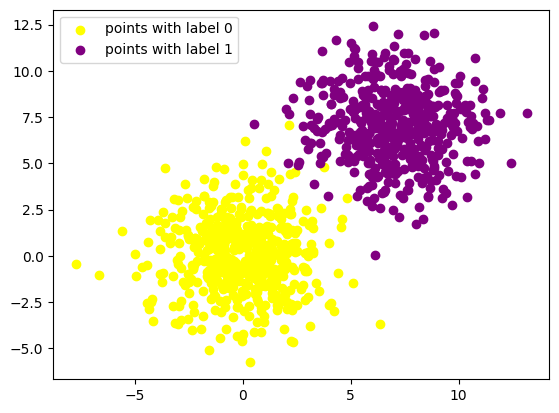

In [191]:
X, y = make_blobs(n_samples=1000, centers=[[0, 0], [7, 7]], cluster_std=[2, 2])

#separate the labelled points between the two classes
X_0=X[np.where(y==0)]
X_1=X[np.where(y==1)]

#plot of the labelled points
plt.scatter(X_0[:, 0], X_0[:, 1], c='yellow',label="points with label 0")
plt.scatter(X_1[:, 0], X_1[:, 1], c='purple',label="points with label 1")

plt.legend(loc="upper left")
plt.show()

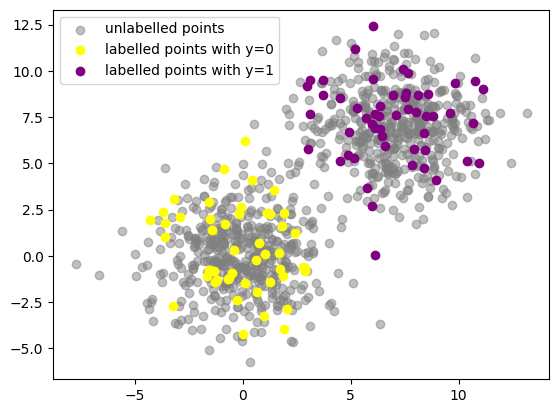

In [192]:
X_labelled,X_unlabelled,y_labelled,y_unlabelled=train_test_split(X,y, test_size=0.9, random_state=0)

#plot labelled and unlabelled points

#divide X_labelled betwee the two classes
X_labelled_0=X_labelled[np.where(y_labelled==0)]
X_labelled_1=X_labelled[np.where(y_labelled==1)]

#plot the different classes
plt.scatter(X_unlabelled[:, 0], X_unlabelled[:, 1], c='gray', alpha=0.5, label="unlabelled points") 
plt.scatter(X_labelled_0[:, 0], X_labelled_0[:, 1], c='yellow', label="labelled points with y=0")
plt.scatter(X_labelled_1[:, 0], X_labelled_1[:, 1], c='purple', label="labelled points with y=1")    

copy_y_unlabelled=y_unlabelled.copy()
for i in range(len(y_unlabelled)):
  y_unlabelled[i]=-1

#print(X_unlabelled)
# Mostrare il grafico
plt.legend(loc="upper left")
plt.show()


Create the weights matrices using the rbf kernel to define the similarity measure

In [193]:
# Compute the pairwise distance matrix
distance_matrix = pairwise_distances(X)

# Compute the weights for the labeled points and the unlabeled points
labelled_indices = np.where(y_labelled != -1)
unlabelled_indices = np.where(y_unlabelled == -1)
gamma = 1 / (2 * np.median(distance_matrix) ** 2)
weights_labelled = rbf_kernel(X_labelled, X_unlabelled, gamma=gamma)
weights_unlabelled = rbf_kernel(distance_matrix[np.ix_(unlabelled_indices[0], labelled_indices[0])], gamma=gamma)

# Compute the weights for the unlabeled-unlabeled points
unlabelled_indices_1, unlabelled_indices_2 = np.meshgrid(unlabelled_indices, unlabelled_indices)
unlabelled_distances = distance_matrix[unlabelled_indices_1, unlabelled_indices_2]
unlabelled_weights = rbf_kernel(unlabelled_distances, gamma=gamma)


print(weights_labelled.shape)
print(weights_unlabelled.shape)

(100, 900)
(900, 900)


We now define the objective function, i.e. the function we want to minimize. In order to do this, we also compute the gradient function

In [194]:
# define objective function
def objective(y_un):
  global y_labelled,weights_labelled,weights_unlabelled
  result = 0
  for i in range(len(y_labelled)):
    for j in range(len(y_un)):
      result += weights_labelled[i][j] *((y_labelled[i] - y_un[j]) ** 2)
  
  for i in range(len(y_un)):
    for j in range(len(y_un)):
      result+=(1/2)*( weights_unlabelled[i][j]*((y_un[i]-y_un[j])**2))
  return result


# define gradient of objective function
def gradient(y_un):
  global y_labelled,weights_labelled,weights_unlabelled
  result = np.zeros(len(y_un))
  for i in range(len(y_labelled)):
    for j in range(len(y_un)):
      result[j] += 2* weights_labelled[i][j] * (y_un[j]-y_labelled[i])
  
  for i in range(len(y_un)):
    for j in range(len(y_un)):
      result[j] +=2* weights_unlabelled[i][j]*(y_un[i]-y_un[j])
  return result

To avoid high computational time we create 2 function that update the gradient at each iteraction and a function to compute the objective function with numpy so all the algorithms will be faster 

In [195]:
#update all the gradient
label_unlabel = np.sum(weights_labelled, axis=0).reshape((-1,1))
unlabel_unlabel = np.sum(weights_unlabelled, axis=0).reshape((-1,1))
coeff_vector = (2 * label_unlabel + unlabel_unlabel)

def update_full_gradient(prev_grad):
  result = np.copy(prev_grad)
  for i in range(len(result)):
    result += weights_unlabelled[i] * alpha*prev_grad[i]   
    result[i] -= coeff_vector[i] * alpha*prev_grad[i]
  return result

#update just one component
def update_gradient(prev_grad,i):
  result = np.copy(prev_grad)
  result += weights_unlabelled[i] * alpha*prev_grad[i]
  result[i] -= coeff_vector[i] * alpha*prev_grad[i]
  return result

def objective_np(y_labelled,y_un):
  global weights_labelled, weights_unlabelled
  result=0
  y_labelled = np.array(y_labelled)  
  weights_labelled = np.array(weights_labelled)
  weights_unlabelled = np.array(weights_unlabelled)

  diff_labelled = y_labelled[:, np.newaxis] - y_un
  result += np.sum(weights_labelled * diff_labelled**2)

  diff_unlabelled = y_un[:, np.newaxis] - y_un
  result += (1/2) * np.sum(weights_unlabelled * diff_unlabelled**2)
  return result

#Finding the optimum learning rate

Largest eigenvalue of the hessian matrix

In [196]:
mat = np.copy(-weights_unlabelled)
for i in range(len(y_unlabelled)):
  mat[i][i] = 2 * np.sum(weights_labelled[:,i]) + np.sum(weights_unlabelled[:,i]) - weights_unlabelled[i][i]

eigvals = np.linalg.eigvals(mat) 
L=max(eigvals)
print(L)
alpha=1/L
print(alpha)

221.39639890037085
0.0045167852998819705


#Gradient descent methods

## Classic gradient descent

In [197]:
#define a maximum number of iteration and epsilon such that if the norm of the gradient is smaller
#than epsilon we stop the method
max_iter=100
EPSILON=1e-4
# the learning rate is the alpha computed with the hessian matrix

In [198]:
# define initial guess
y_unl=np.zeros(len(y_unlabelled))+1
objective_f=[]
# run gradient descent algorithm
start_time = time.perf_counter()
times=[]
accuracies=[]
grad=gradient(y_unl)
for iter in range(max_iter):
    y_unl = y_unl - alpha * grad
    current_time = time.perf_counter()
    times.append(current_time-start_time)
    accuracies.append(accuracy_score(copy_y_unlabelled, np.round(y_unl)))
    obj=objective_np(y_labelled,y_unl)
    objective_f.append(obj)
    grad=update_full_gradient(grad)
    if EPSILON >= np.linalg.norm(grad):
        break
y_unl=np.clip(y_unl,0,1)
y_unl=np.round(y_unl)
end_time = time.perf_counter()
# print solution and number of ierations
print("Minimum point:", y_unl)
print("Number of iteration",iter+1)

Minimum point: [0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1.
 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0.
 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0.
 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0.
 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1.
 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1.
 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0.
 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0.
 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1.
 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1.
 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1.
 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0.
 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1.

Text(0.5, 1.0, 'Accuracy classic GD')

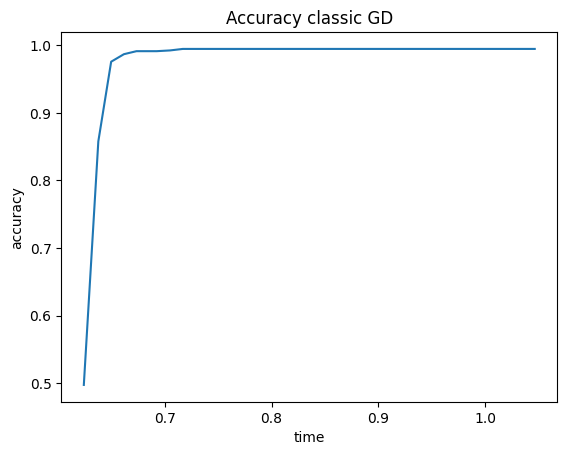

In [199]:
plt.plot(times,accuracies)
plt.xlabel("time")
plt.ylabel("accuracy")
plt.title("Accuracy classic GD")

Text(0.5, 1.0, 'Loss function classic GD')

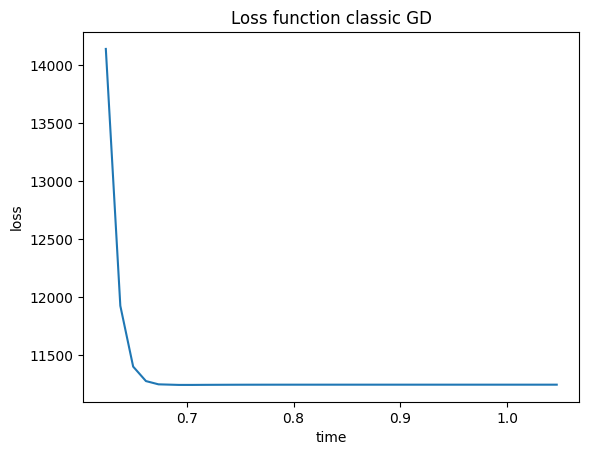

In [200]:
#plot loss
plt.plot(times,objective_f)
plt.xlabel("time")
plt.ylabel("loss")
plt.title("Loss function classic GD")

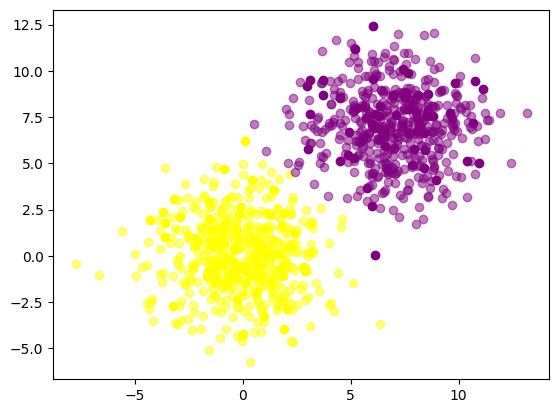

Accuracy: 0.9944444444444445


In [201]:
#plot of the label assigned and the labelled points

#separate the labelled points between the two classes
X_labelled_0=X_labelled[np.where(y_labelled==0)]
X_labelled_1=X_labelled[np.where(y_labelled==1)]

#separate the unlabelled points between the two predicted classes
X_unlabelled_0=X_unlabelled[np.where(y_unl==0)]
X_unlabelled_1=X_unlabelled[np.where(y_unl==1)]

#plot of the labelled points
plt.scatter(X_labelled_0[:, 0], X_labelled_0[:, 1], c='yellow')
plt.scatter(X_labelled_1[:, 0], X_labelled_1[:, 1], c='purple')

#plot of the unlabelled points
plt.scatter(X_unlabelled_0[:, 0], X_unlabelled_0[:, 1], c='yellow', alpha=0.5)
plt.scatter(X_unlabelled_1[:, 0], X_unlabelled_1[:, 1], c='purple',alpha=0.5)

plt.show()

#accuracy score
accuracy = accuracy_score(copy_y_unlabelled, y_unl)
print("Accuracy:", accuracy)

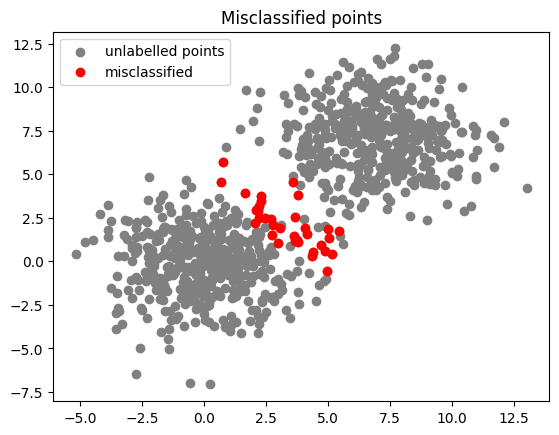

In [ ]:
#plot of just the misclassified points
misclassified_points=[]
for i in range(len(y_unl)):
  if y_unl[i]!=copy_y_unlabelled[i]:
    misclassified_points.append(X_unlabelled[i])
misclassified_points_matrix=np.zeros((len(misclassified_points),2))
for i in range(len(misclassified_points)):
  misclassified_points_matrix[i,:]=misclassified_points[i]
plt.scatter(X_unlabelled[:, 0], X_unlabelled[:, 1], c='grey',label="unlabelled points")  #unlabelled points
plt.scatter(misclassified_points_matrix[:,0],misclassified_points_matrix[:,1],c='red',label="misclassified") #misclassified points
plt.legend(loc="upper left")
plt.title("Misclassified points")
plt.show()

## BCGD with randomized rule

In [202]:
#define initial value
y_unl_bcgd=np.zeros(len(y_unlabelled))+.5
previous_grad=gradient(y_unl_bcgd)
obj_f=[]
obj=objective(y_unl_bcgd)
times2=[]
accuracies2=[]
max_iter=max_iter*len(y_unl_bcgd)
start_time=time.perf_counter()
for iter in range(max_iter):
  i=random.randint(0,len(y_unl_bcgd)-1)
  prev=y_unl_bcgd.copy()
  y_unl_bcgd[i]= y_unl_bcgd[i] - alpha * previous_grad[i]
  previous_grad=update_gradient(previous_grad,i)
  #print(new_obj)
  #print(obj)
  #print(loss(y_labelled,y_unl_bcgd))
  obj=objective_np(y_labelled,y_unl_bcgd)
  current_time=time.perf_counter()
  obj_f.append(obj)
  times2.append(current_time-start_time)
  accuracies2.append(accuracy_score(copy_y_unlabelled, np.round(y_unl_bcgd)))
  if EPSILON >= np.linalg.norm(previous_grad):
        break

y_unl_bcgd=np.clip(y_unl_bcgd,0,1)
y_unl_bcgd=np.round(y_unl_bcgd)

#print solution and number of iterations
print("Minimum point:", y_unl_bcgd)
print("Number of iteration",iter+1)

Minimum point: [0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1.
 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0.
 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0.
 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0.
 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1.
 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1.
 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0.
 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0.
 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1.
 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1.
 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1.
 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0.
 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1.

Text(0.5, 1.0, 'Accuracy BCGD with randomized rule')

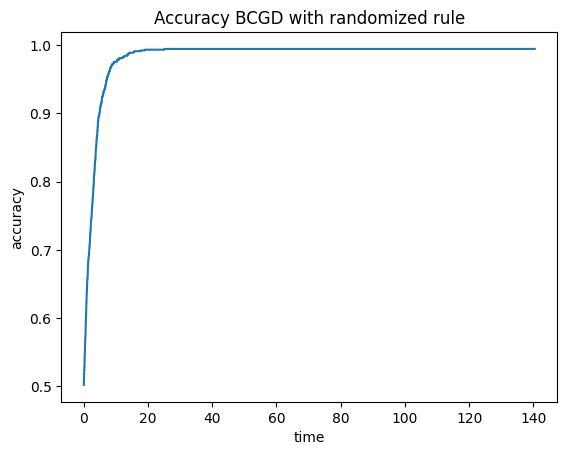

In [203]:
plt.plot(times2,accuracies2)
plt.xlabel("time")
plt.ylabel("accuracy")
plt.title("Accuracy BCGD with randomized rule")

Text(0.5, 1.0, 'Loss function BCGD with randomized rule')

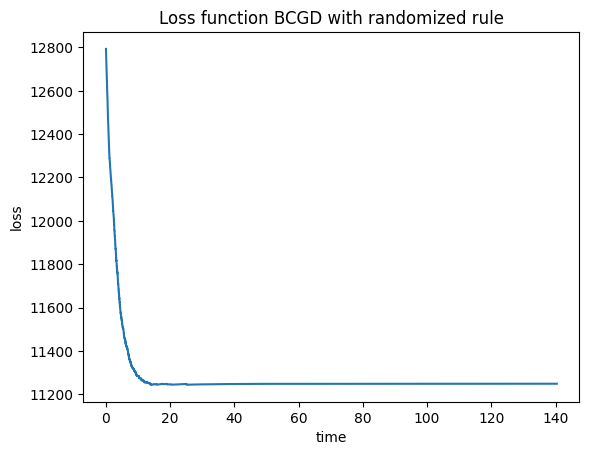

In [204]:
plt.plot(times2,obj_f)
plt.xlabel("time")
plt.ylabel("loss")
plt.title("Loss function BCGD with randomized rule")

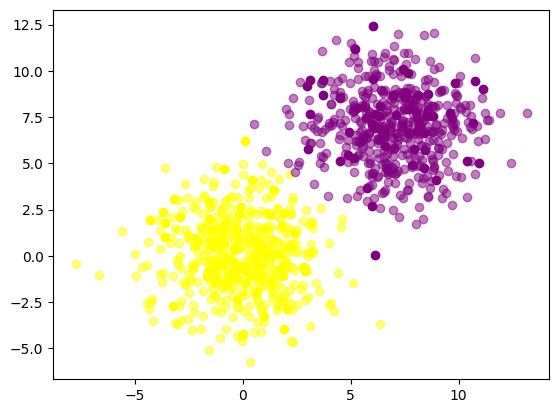

Accuracy: 0.9944444444444445


In [205]:
#plot of the label assigned and the labelled points

#separate the labelled points between the two classes
X_labelled_0=X_labelled[np.where(y_labelled==0)]
X_labelled_1=X_labelled[np.where(y_labelled==1)]

#separate the unlabelled points between the two predicted classes
X_unlabelled_0=X_unlabelled[np.where(y_unl_bcgd==0)]
X_unlabelled_1=X_unlabelled[np.where(y_unl_bcgd==1)]

#plot of the labelled points
plt.scatter(X_labelled_0[:, 0], X_labelled_0[:, 1], c='yellow')
plt.scatter(X_labelled_1[:, 0], X_labelled_1[:, 1], c='purple')

#plot of the unlabelled points
plt.scatter(X_unlabelled_0[:, 0], X_unlabelled_0[:, 1], c='yellow', alpha=0.5)
plt.scatter(X_unlabelled_1[:, 0], X_unlabelled_1[:, 1], c='purple',alpha=0.5)

plt.show()

#accuracy score
accuracy = accuracy_score(copy_y_unlabelled, y_unl_bcgd)
print("Accuracy:", accuracy)

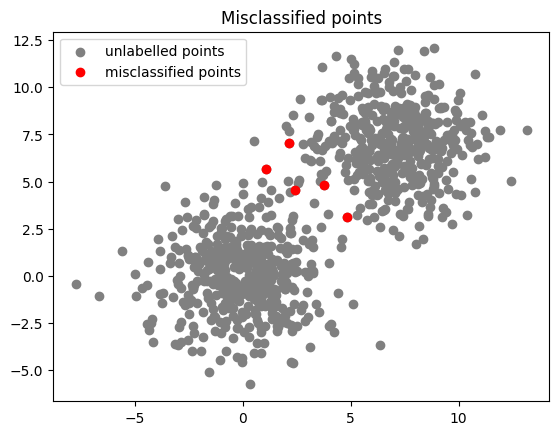

5


In [206]:
#plot of the misclassified points
misclassified_points=[]
for i in range(len(y_unl_bcgd)):
  if y_unl_bcgd[i]!=copy_y_unlabelled[i]:
    misclassified_points.append(X_unlabelled[i])
misclassified_points_matrix=np.zeros((len(misclassified_points),2))
for i in range(len(misclassified_points)):
  misclassified_points_matrix[i,:]=misclassified_points[i]
plt.scatter(X_unlabelled[:, 0], X_unlabelled[:, 1], c='grey', label="unlabelled points")  # Tracciare i punti unlabelled
plt.scatter(misclassified_points_matrix[:,0],misclassified_points_matrix[:,1],c='red',label="misclassified points")
plt.legend(loc="upper left")
plt.title("Misclassified points")
plt.show()

## BCGD with Gauss Southwell rule

In [ ]:
y_unl_gs=np.zeros(len(y_unlabelled))+.5
previous_grad=gradient(y_unl_gs)
obj_f_gs=[]
times3=[]
start_time=time.perf_counter()
accuracies3=[]
for iter in range(max_iter*len(y_unl_gs)):
  abs_previous_grad=np.abs(previous_grad)
  i=np.argmax(abs_previous_grad)  
  y_unl_gs[i]= y_unl_gs[i] - alpha * previous_grad[i]
  previous_grad=update_gradient(previous_grad,i)
  obj=objective_np(y_labelled,y_unl_gs)
  current_time=time.perf_counter()
  times3.append(current_time-start_time)
  accuracies3.append(accuracy_score(copy_y_unlabelled,np.round( y_unl_gs)))
  obj_f_gs.append(obj)
  if EPSILON >= np.linalg.norm(previous_grad):
    break
y_unl_gs=np.clip(y_unl_gs,0,1)
y_unl_gs=np.round(y_unl_gs)

#print solution and number of iterations
print("Minimum point:", y_unl_gs)
print("Number of iteration",iter+1)

Minimum point: [0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1.
 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1.
 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1.
 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0.
 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0.
 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0.
 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1.
 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1.
 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1.
 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1.
 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.

Text(0.5, 1.0, 'Accuracy BCGD with GS rule')

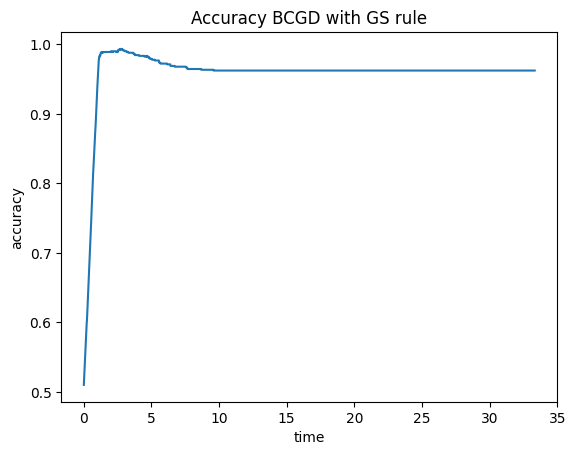

In [ ]:
plt.plot(times3,accuracies3)
plt.xlabel("time")
plt.ylabel("accuracy")
plt.title("Accuracy BCGD with GS rule")

Text(0.5, 1.0, 'Loss function BCGD with GS rule')

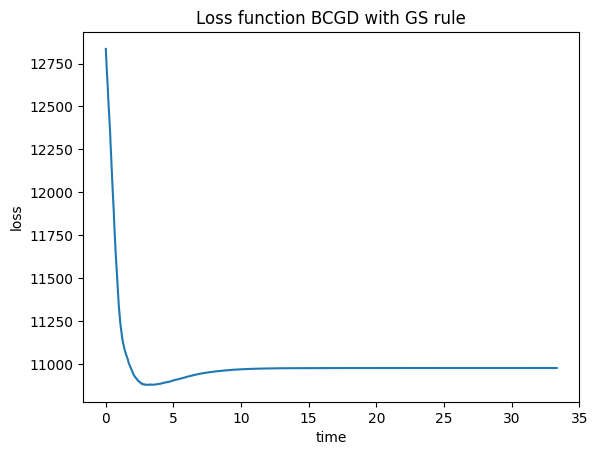

In [ ]:
plt.plot(times3,obj_f_gs)
plt.xlabel("time")
plt.ylabel("loss")
plt.title("Loss function BCGD with GS rule")

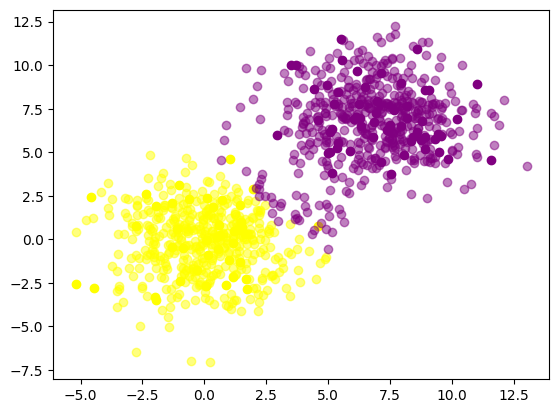

Accuracy: 0.9622222222222222


In [ ]:
#plot of the label assigned and the labelled points

#separate the labelled points between the two classes
X_labelled_0=X_labelled[np.where(y_labelled==0)]
X_labelled_1=X_labelled[np.where(y_labelled==1)]

#separate the unlabelled points between the two predicted classes
X_unlabelled_0=X_unlabelled[np.where(y_unl_gs==0)]
X_unlabelled_1=X_unlabelled[np.where(y_unl_gs==1)]

#plot of the labelled points
plt.scatter(X_labelled_0[:, 0], X_labelled_0[:, 1], c='yellow')
plt.scatter(X_labelled_1[:, 0], X_labelled_1[:, 1], c='purple')

#plot of the unlabelled points
plt.scatter(X_unlabelled_0[:, 0], X_unlabelled_0[:, 1], c='yellow', alpha=0.5)
plt.scatter(X_unlabelled_1[:, 0], X_unlabelled_1[:, 1], c='purple',alpha=0.5)

plt.show()

#accuracy score
accuracy = accuracy_score(copy_y_unlabelled, y_unl_gs)
print("Accuracy:", accuracy)

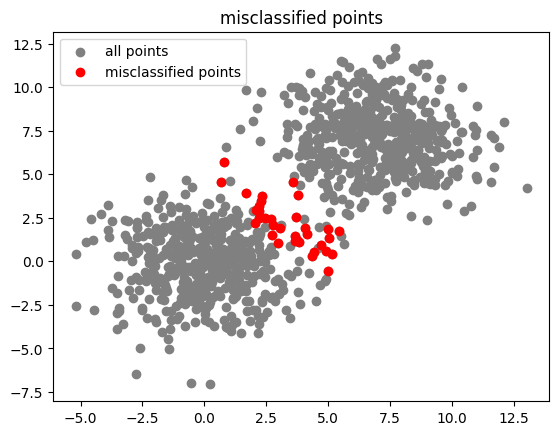

In [ ]:
#plot of the misclassified points
misclassified_points=[]
for i in range(len(y_unl_bcgd)):
  if y_unl_bcgd[i]!=copy_y_unlabelled[i]:
    misclassified_points.append(X_unlabelled[i])
misclassified_points_matrix=np.zeros((len(misclassified_points),2))
for i in range(len(misclassified_points)):
  misclassified_points_matrix[i,:]=misclassified_points[i]
plt.scatter(X_labelled[:, 0], X_labelled[:, 1], c='grey',label="all points")  # Tracciare i punti labelled
plt.scatter(X_unlabelled[:, 0], X_unlabelled[:, 1], c='grey')  # Tracciare i punti unlabelled
plt.scatter(misclassified_points_matrix[:,0],misclassified_points_matrix[:,1],c='red',label="misclassified points")
plt.legend(loc="upper left")
plt.title("misclassified points")
plt.show()

#Dataset

## Breast cancer dataset

Import the dataset and creating a plot

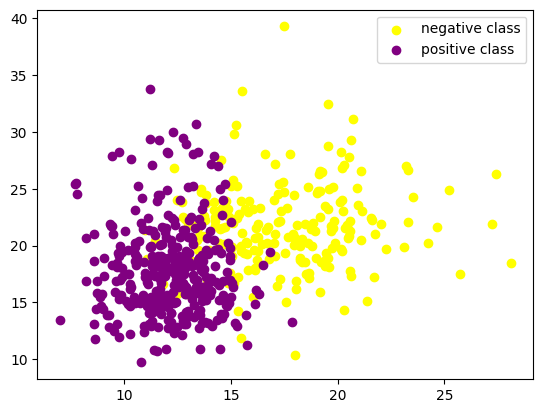

In [ ]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
#we just selected the first 2 features
X, y = data.data[:,[0,1]], data.target


#plot of the label assigned and the labelled points

#separate the labelled points between the two classes
X_0=X[np.where(y==0)]
X_1=X[np.where(y==1)]

#plot of the labelled points
plt.scatter(X_0[:, 0], X_0[:, 1], c='yellow',label="negative class")
plt.scatter(X_1[:, 0], X_1[:, 1], c='purple',label="positive class")

plt.legend(loc="upper right")
plt.show()

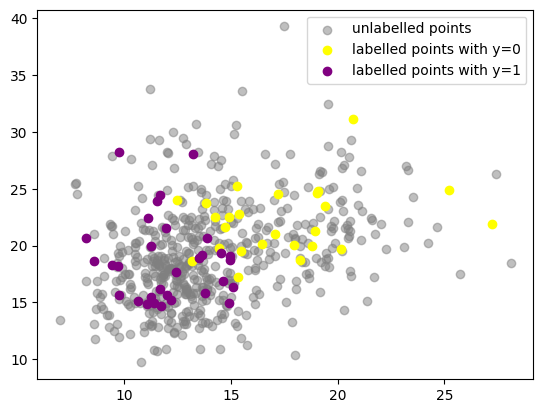

In [ ]:
#remove the label from most of the points
from sklearn.model_selection import train_test_split
X_labelled,X_unlabelled,y_labelled,y_unlabelled=train_test_split(X,y, test_size=0.9, random_state=0)

#divide X_labelled betwee the two classes
X_labelled_0=X_labelled[np.where(y_labelled==0)]
X_labelled_1=X_labelled[np.where(y_labelled==1)]

#plot the different classes
plt.scatter(X_unlabelled[:, 0], X_unlabelled[:, 1], c='gray', alpha=0.5, label="unlabelled points") 
plt.scatter(X_labelled_0[:, 0], X_labelled_0[:, 1], c='yellow', label="labelled points with y=0")
plt.scatter(X_labelled_1[:, 0], X_labelled_1[:, 1], c='purple', label="labelled points with y=1")   

copy_y_unlabelled=y_unlabelled.copy()
for i in range(len(y_unlabelled)):
  y_unlabelled[i]=-1

plt.legend(loc="upper right")
plt.show()

Create the matrix of the weights

In [ ]:
from sklearn.metrics.pairwise import rbf_kernel, pairwise_distances
import numpy as np
# Compute the pairwise distance matrix
distance_matrix = pairwise_distances(X)
#print(distance_matrix)

# Compute the weights for the labeled points and the unlabeled points
labelled_indices = np.where(y_labelled != -1)
unlabelled_indices = np.where(y_unlabelled == -1)
gamma = 1 / (2 * np.median(distance_matrix) ** 2)
weights_labelled = rbf_kernel(X_labelled, X_unlabelled, gamma=gamma)
weights_unlabelled = rbf_kernel(distance_matrix[np.ix_(unlabelled_indices[0], labelled_indices[0])], gamma=gamma)

# Compute the weights for the unlabeled-unlabeled points
unlabelled_indices_1, unlabelled_indices_2 = np.meshgrid(unlabelled_indices, unlabelled_indices)
unlabelled_distances = distance_matrix[unlabelled_indices_1, unlabelled_indices_2]
unlabelled_weights = rbf_kernel(unlabelled_distances, gamma=gamma)

In [ ]:
# define objective function
def objective(y_un):
  global y_labelled,weights_labelled,weights_unlabelled
  result = 0
  for i in range(len(y_labelled)):
    for j in range(len(y_un)):
      result += weights_labelled[i][j] *((y_labelled[i] - y_un[j]) ** 2)
  
  for i in range(len(y_un)):
    for j in range(len(y_un)):
      result+=(1/2)*( weights_unlabelled[i][j]*((y_un[i]-y_un[j])**2))
  return result


# define gradient of objective function
def gradient(y_un):
  global y_labelled,weights_labelled,weights_unlabelled
  result = np.zeros(len(y_un))
  for i in range(len(y_labelled)):
    for j in range(len(y_un)):
      result[j] += 2* weights_labelled[i][j] * (y_un[j]-y_labelled[i])
  
  for i in range(len(y_un)):
    for j in range(len(y_un)):
      result[j] +=2* weights_unlabelled[i][j]*(y_un[i]-y_un[j])
  return result

In [ ]:
#update all the gradient
label_unlabel = np.sum(weights_labelled, axis=0).reshape((-1,1))
unlabel_unlabel = np.sum(weights_unlabelled, axis=0).reshape((-1,1))
coeff_vector = (2 * label_unlabel + unlabel_unlabel)

def update_full_gradient(prev_grad):
  result = np.copy(prev_grad)
  for i in range(len(result)):
    result += weights_unlabelled[i] * alpha*prev_grad[i]   
    result[i] -= coeff_vector[i] * alpha*prev_grad[i]
  return result

#update just one component
def update_gradient(prev_grad,i):
  result = np.copy(prev_grad)
  result += weights_unlabelled[i] * alpha*prev_grad[i]
  result[i] -= coeff_vector[i] * alpha*prev_grad[i]
  return result

def objective_np(y_labelled,y_un):
  global weights_labelled, weights_unlabelled
  result=0
  y_labelled = np.array(y_labelled)  
  weights_labelled = np.array(weights_labelled)
  weights_unlabelled = np.array(weights_unlabelled)

  diff_labelled = y_labelled[:, np.newaxis] - y_un
  result += np.sum(weights_labelled * diff_labelled**2)

  diff_unlabelled = y_un[:, np.newaxis] - y_un
  result += (1/2) * np.sum(weights_unlabelled * diff_unlabelled**2)
  return result

Finding the optimal learning rate

Hessian matrix

In [ ]:
mat = np.copy(-weights_unlabelled)
for i in range(len(y_unlabelled)):
  mat[i][i] = 2 * np.sum(weights_labelled[:,i]) + np.sum(weights_unlabelled[:,i]) - weights_unlabelled[i][i]

eigvals = np.linalg.eigvals(mat) 
L=max(eigvals)
print(L)
alpha=1/L
print(alpha)

154.56986529675052
0.006469566354865826


Define the parameters

In [ ]:
#define a maximum number of iteration and epsilon such that if the norm of the gradient is smaller
#than epsilon we stop the method
max_iter=100
EPSILON=1e-4
# the learning rate is already defined

### Classic gradient descent

In [ ]:
# define initial guess
y_unl=np.zeros(len(y_unlabelled))+1
objective_f=[]
# run gradient descent algorithm
start_time = time.perf_counter()
times=[]
accuracies=[]
grad=gradient(y_unl)
for iter in range(max_iter):
    y_unl = y_unl - alpha * grad
    current_time = time.perf_counter()
    times.append(current_time-start_time)
    accuracies.append(accuracy_score(copy_y_unlabelled, np.round(y_unl)))
    obj=objective_np(y_labelled,y_unl)
    objective_f.append(obj)
    grad=update_full_gradient(grad)
    if EPSILON >= np.linalg.norm(grad):
        break
y_unl=np.clip(y_unl,0,1)
y_unl=np.round(y_unl)
end_time = time.perf_counter()
# print solution and number of ierations
print("Minimum point:", y_unl)
print("Number of iteration",iter+1)

Minimum point: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1.
 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1.
 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0.
 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.

Text(0.5, 1.0, 'Accuracy classic GD')

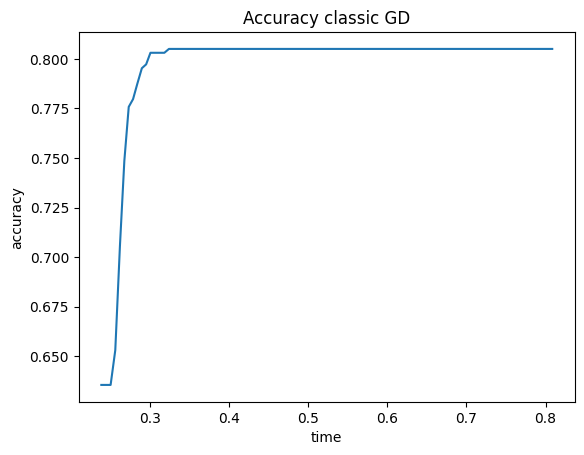

In [ ]:
plt.plot(times,accuracies)
plt.xlabel("time")
plt.ylabel("accuracy")
plt.title("Accuracy classic GD")

Text(0.5, 1.0, 'Loss function classic GD')

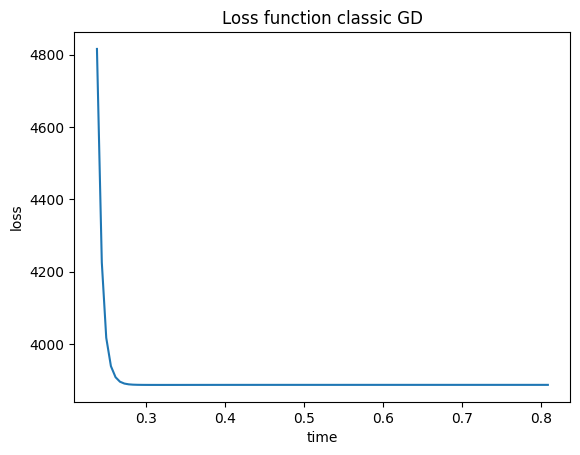

In [ ]:
#plot loss
plt.plot(times,objective_f)
plt.xlabel("time")
plt.ylabel("loss")
plt.title("Loss function classic GD")

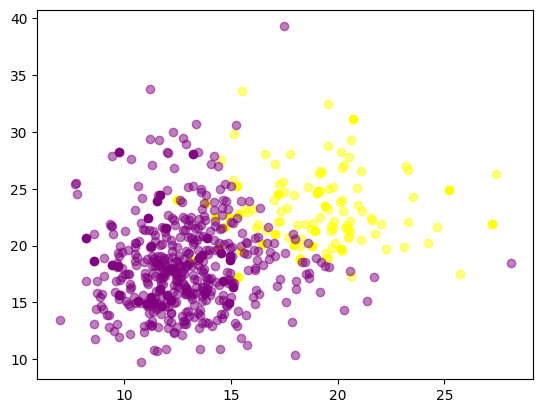

Accuracy: 0.8050682261208577


In [ ]:
#plot of the label assigned and the labelled points

#separate the labelled points between the two classes
X_labelled_0=X_labelled[np.where(y_labelled==0)]
X_labelled_1=X_labelled[np.where(y_labelled==1)]

#separate the unlabelled points between the two predicted classes
X_unlabelled_0=X_unlabelled[np.where(y_unl==0)]
X_unlabelled_1=X_unlabelled[np.where(y_unl==1)]

#plot of the labelled points
plt.scatter(X_labelled_0[:, 0], X_labelled_0[:, 1], c='yellow')
plt.scatter(X_labelled_1[:, 0], X_labelled_1[:, 1], c='purple')

#plot of the unlabelled points
plt.scatter(X_unlabelled_0[:, 0], X_unlabelled_0[:, 1], c='yellow', alpha=0.5)
plt.scatter(X_unlabelled_1[:, 0], X_unlabelled_1[:, 1], c='purple',alpha=0.5)

plt.show()

#accuracy score
accuracy = accuracy_score(copy_y_unlabelled, y_unl)
print("Accuracy:", accuracy)

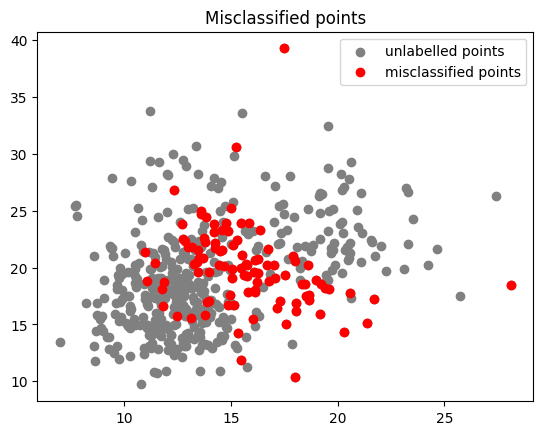

In [ ]:
#plot of just the misclassified points
misclassified_points=[]
for i in range(len(y_unl)):
  if y_unl[i]!=copy_y_unlabelled[i]:
    misclassified_points.append(X_unlabelled[i])
misclassified_points_matrix=np.zeros((len(misclassified_points),2))
for i in range(len(misclassified_points)):
  misclassified_points_matrix[i,:]=misclassified_points[i]
plt.scatter(X_unlabelled[:, 0], X_unlabelled[:, 1], c='grey', label="unlabelled points") 
plt.scatter(misclassified_points_matrix[:,0],misclassified_points_matrix[:,1],c='red', label="misclassified points")
plt.legend(loc="upper right")
plt.title("Misclassified points")
plt.show()

### BCGD with randomized rule

In [ ]:
#define initial value
y_unl_bcgd=np.zeros(len(y_unlabelled))+.5
previous_grad=gradient(y_unl_bcgd)
obj_f=[]
obj=objective(y_unl_bcgd)
times2=[]
accuracies2=[]
max_iter=max_iter*len(y_unl_bcgd)
start_time=time.perf_counter()
for iter in range(max_iter):
  i=random.randint(0,len(y_unl_bcgd)-1)
  prev=y_unl_bcgd.copy()
  y_unl_bcgd[i]= y_unl_bcgd[i] - alpha * previous_grad[i]
  previous_grad=update_gradient(previous_grad,i)
  #print(new_obj)
  #print(obj)
  #print(loss(y_labelled,y_unl_bcgd))
  obj=objective_np(y_labelled,y_unl_bcgd)
  current_time=time.perf_counter()
  obj_f.append(obj)
  times2.append(current_time-start_time)
  accuracies2.append(accuracy_score(copy_y_unlabelled, np.round(y_unl_bcgd)))
  if EPSILON >= np.linalg.norm(previous_grad):
        break

y_unl_bcgd=np.clip(y_unl_bcgd,0,1)
y_unl_bcgd=np.round(y_unl_bcgd)

#print solution and number of iterations
print("Minimum point:", y_unl_bcgd)
print("Number of iteration",iter+1)

Minimum point: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1.
 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1.
 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0.
 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.

Text(0.5, 1.0, 'Accuracy BCGD with randomized rule')

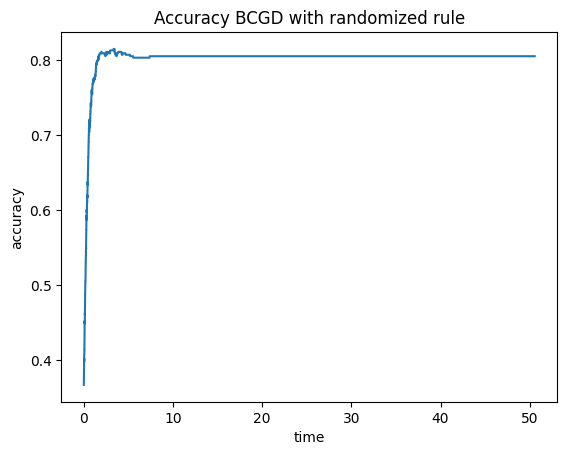

In [ ]:
plt.plot(times2,accuracies2)
plt.xlabel("time")
plt.ylabel("accuracy")
plt.title("Accuracy BCGD with randomized rule")

Text(0.5, 1.0, 'Loss function BCGD with randomized rule')

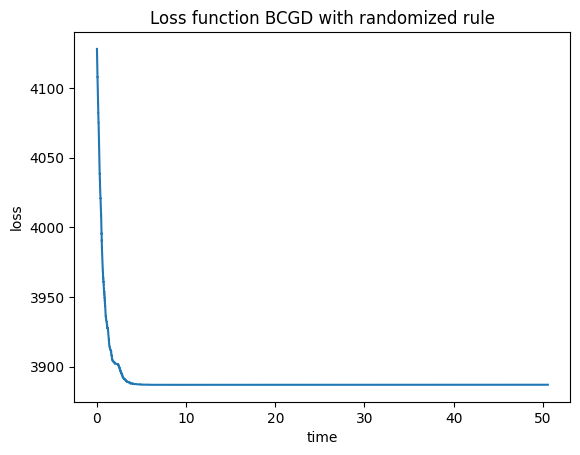

In [ ]:
plt.plot(times2,obj_f)
plt.xlabel("time")
plt.ylabel("loss")
plt.title("Loss function BCGD with randomized rule")

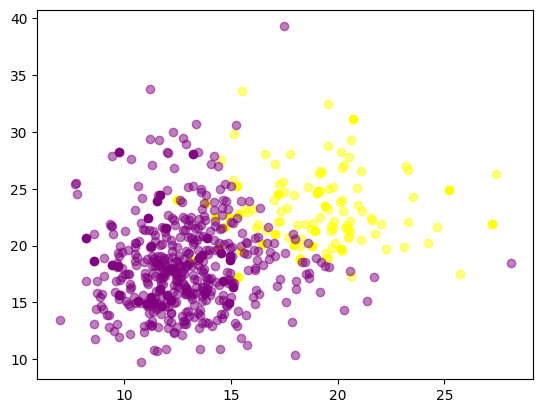

Accuracy: 0.8050682261208577


In [ ]:
#plot of the label assigned and the labelled points

#separate the labelled points between the two classes
X_labelled_0=X_labelled[np.where(y_labelled==0)]
X_labelled_1=X_labelled[np.where(y_labelled==1)]

#separate the unlabelled points between the two predicted classes
X_unlabelled_0=X_unlabelled[np.where(y_unl_bcgd==0)]
X_unlabelled_1=X_unlabelled[np.where(y_unl_bcgd==1)]

#plot of the labelled points
plt.scatter(X_labelled_0[:, 0], X_labelled_0[:, 1], c='yellow')
plt.scatter(X_labelled_1[:, 0], X_labelled_1[:, 1], c='purple')

#plot of the unlabelled points
plt.scatter(X_unlabelled_0[:, 0], X_unlabelled_0[:, 1], c='yellow', alpha=0.5)
plt.scatter(X_unlabelled_1[:, 0], X_unlabelled_1[:, 1], c='purple',alpha=0.5)

plt.show()

#accuracy score
accuracy = accuracy_score(copy_y_unlabelled, y_unl_bcgd)
print("Accuracy:", accuracy)

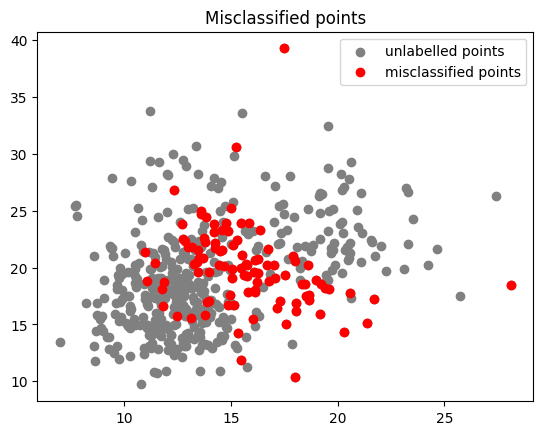

In [ ]:
#plot of just the misclassified points
misclassified_points=[]
for i in range(len(y_unl_bcgd)):
  if y_unl_bcgd[i]!=copy_y_unlabelled[i]:
    misclassified_points.append(X_unlabelled[i])
misclassified_points_matrix=np.zeros((len(misclassified_points),2))
for i in range(len(misclassified_points)):
  misclassified_points_matrix[i,:]=misclassified_points[i]
plt.scatter(X_unlabelled[:, 0], X_unlabelled[:, 1], c='grey', label="unlabelled points")
plt.scatter(misclassified_points_matrix[:,0],misclassified_points_matrix[:,1],c='red', label="misclassified points")
plt.legend(loc="upper right")
plt.title("Misclassified points")
plt.show()

### BCGD with GS rule

In [ ]:
y_unl_gs=np.zeros(len(y_unlabelled))+.5
previous_grad=gradient(y_unl_gs)
obj_f_gs=[]
times3=[]
start_time=time.perf_counter()
accuracies3=[]
for iter in range(max_iter*len(y_unl_gs)):
  abs_previous_grad=np.abs(previous_grad)
  i=np.argmax(abs_previous_grad)  
  y_unl_gs[i]= y_unl_gs[i] - alpha * previous_grad[i]
  previous_grad=update_gradient(previous_grad,i)
  obj=objective_np(y_labelled,y_unl_gs)
  current_time=time.perf_counter()
  times3.append(current_time-start_time)
  accuracies3.append(accuracy_score(copy_y_unlabelled,np.round( y_unl_gs)))
  obj_f_gs.append(obj)
  if EPSILON >= np.linalg.norm(previous_grad):
    break
y_unl_gs=np.clip(y_unl_gs,0,1)
y_unl_gs=np.round(y_unl_gs)

#print solution and number of iterations
print("Minimum point:", y_unl_gs)
print("Number of iteration",iter+1)

Minimum point: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1.
 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1.
 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0.
 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.

Text(0.5, 1.0, 'Accuracy BCGD with GS rule')

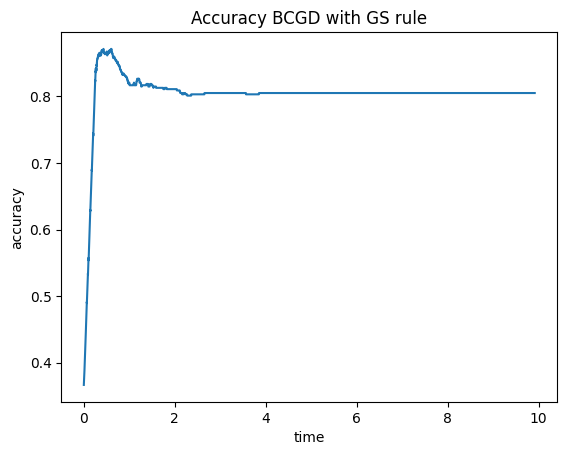

In [ ]:
plt.plot(times3,accuracies3)
plt.xlabel("time")
plt.ylabel("accuracy")
plt.title("Accuracy BCGD with GS rule")

Text(0.5, 1.0, 'Loss function BCGD with GS rule')

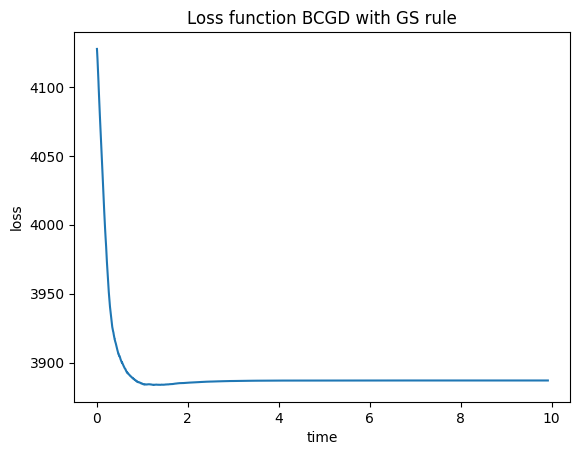

In [ ]:
plt.plot(times3,obj_f_gs)
plt.xlabel("time")
plt.ylabel("loss")
plt.title("Loss function BCGD with GS rule")

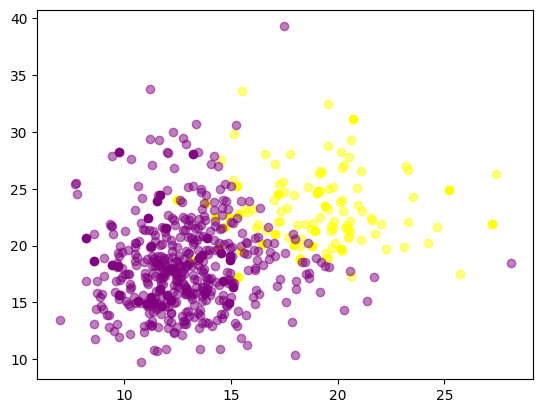

Accuracy: 0.8050682261208577


In [ ]:
#plot of the label assigned and the labelled points

#separate the labelled points between the two classes
X_labelled_0=X_labelled[np.where(y_labelled==0)]
X_labelled_1=X_labelled[np.where(y_labelled==1)]

#separate the unlabelled points between the two predicted classes
X_unlabelled_0=X_unlabelled[np.where(y_unl_gs==0)]
X_unlabelled_1=X_unlabelled[np.where(y_unl_gs==1)]

#plot of the labelled points
plt.scatter(X_labelled_0[:, 0], X_labelled_0[:, 1], c='yellow')
plt.scatter(X_labelled_1[:, 0], X_labelled_1[:, 1], c='purple')

#plot of the unlabelled points
plt.scatter(X_unlabelled_0[:, 0], X_unlabelled_0[:, 1], c='yellow', alpha=0.5)
plt.scatter(X_unlabelled_1[:, 0], X_unlabelled_1[:, 1], c='purple',alpha=0.5)

plt.show()

#accuracy score
accuracy = accuracy_score(copy_y_unlabelled, y_unl_gs)
print("Accuracy:", accuracy)

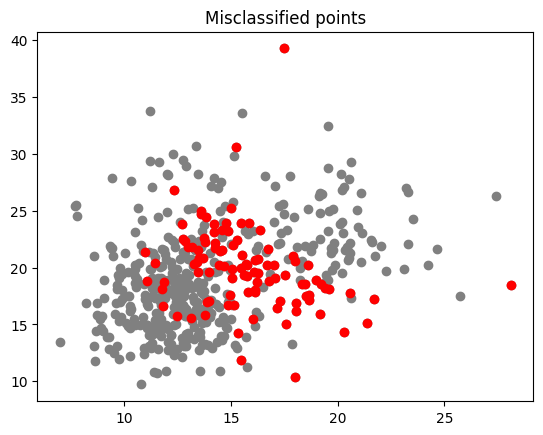

In [ ]:
#plot of just the misclassified points
misclassified_points=[]
for i in range(len(y_unl_gs)):
  if y_unl_gs[i]!=copy_y_unlabelled[i]:
    misclassified_points.append(X_unlabelled[i])
misclassified_points_matrix=np.zeros((len(misclassified_points),2))
for i in range(len(misclassified_points)):
  misclassified_points_matrix[i,:]=misclassified_points[i]
plt.scatter(X_unlabelled[:, 0], X_unlabelled[:, 1], c='grey', label="unlabelled points")
plt.scatter(misclassified_points_matrix[:,0],misclassified_points_matrix[:,1],c='red',label="misclassified points")
plt.title("Misclassified points")
plt.show()

## Male and Female dataset

In [ ]:
from google.colab import files
files.upload()

Saving Training set.csv to Training set.csv


{'Training set.csv': b'\xef\xbb\xbfHeight,Weight,Sex\r\n165.65,35.41,Female\r\n148.53,74.45,Female\r\n167.04,81.22,Male\r\n161.54,71.47,Male\r\n174.31,78.18,Male\r\n143.05,79.27,Female\r\n149.16,63.71,Female\r\n155.80,86.01,Female\r\n145.37,88.33,Female\r\n162.56,87.36,Male\r\n163.84,78.58,Male\r\n172.73,88.08,Male\r\n142.03,56.30,Female\r\n150.17,53.46,Female\r\n188.62,60.95,Male\r\n184.62,72.51,Male\r\n168.43,86.80,Male\r\n171.19,54.12,Male\r\n137.10,73.36,Female\r\n149.42,69.20,Female\r\n147.33,56.01,Female\r\n175.14,107.25,Male\r\n168.04,92.24,Male\r\n158.54,64.44,Male\r\n138.90,68.75,Female\r\n129.27,58.43,Female\r\n173.64,59.52,Female\r\n175.26,62.65,Male\r\n180.09,44.07,Male\r\n144.58,83.36,Female\r\n178.76,66.12,Male\r\n151.53,91.02,Male\r\n168.55,80.20,Male\r\n160.86,63.68,Male\r\n183.83,62.75,Male\r\n179.27,50.04,Male\r\n158.89,60.49,Male\r\n124.37,74.57,Female\r\n140.42,54.64,Female\r\n155.06,84.34,Male\r\n166.62,75.18,Male\r\n172.96,78.39,Male\r\n174.34,84.76,Male\r\n165.09

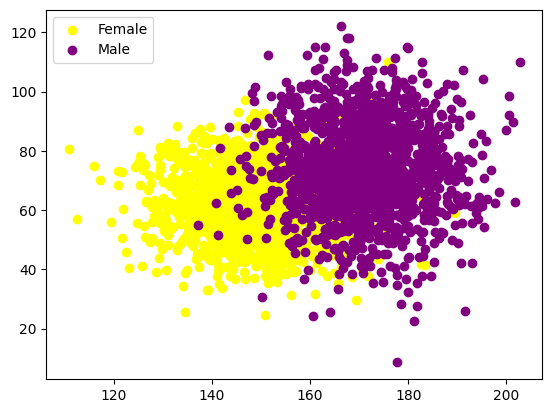

In [ ]:
from sklearn.cluster import KMeans
data=pd.read_csv("Training set.csv")
#removing the outliers in order to have a clear plot
data=data[data['Height']<=1000]
data=data[data['Weight']<200]
data=data[data['Height']>90]


X = np.column_stack((data.Height, data.Weight))
y=data.Sex.values
#changing the value of y to obtain 0/1 instead of "Male"/"Female"
for i in range(len(y)):
  if y[i]=='Female':
    y[i]=0
  else:
    y[i]=1
y = np.array(y).astype(float)

#plot of the label assigned and the labelled points

#separate the labelled points between the two classes
X_0=X[np.where(y==0)]
X_1=X[np.where(y==1)]

#plot of the labelled points
plt.scatter(X_0[:, 0], X_0[:, 1], c='yellow',label="Female")
plt.scatter(X_1[:, 0], X_1[:, 1], c='purple',label="Male")

plt.legend(loc="upper left")
plt.show()

In order to test our model on 2 separate clusters we remove the point in the middle by taking out the point too close to the center of the other cluster

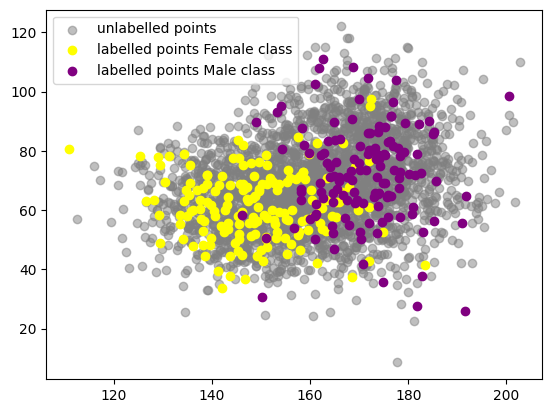

In [ ]:
from sklearn.model_selection import train_test_split
X_labelled,X_unlabelled,y_labelled,y_unlabelled=train_test_split(X,y, test_size=0.9, random_state=0)
#divide X_labelled betwee the two classes
X_labelled_0=X_labelled[np.where(y_labelled==0)]
X_labelled_1=X_labelled[np.where(y_labelled==1)]

#plot the different classes
plt.scatter(X_unlabelled[:, 0], X_unlabelled[:, 1], c='gray', alpha=0.5, label="unlabelled points") 
plt.scatter(X_labelled_0[:, 0], X_labelled_0[:, 1], c='yellow', label="labelled points Female class")
plt.scatter(X_labelled_1[:, 0], X_labelled_1[:, 1], c='purple', label="labelled points Male class")   

copy_y_unlabelled=y_unlabelled.copy()
for i in range(len(y_unlabelled)):
  y_unlabelled[i]=-1

plt.legend(loc="upper left")
plt.show()

Matrices of weights

In [ ]:
# Compute the pairwise distance matrix
distance_matrix = pairwise_distances(X)
#print(distance_matrix)

# Compute the weights for the labeled points and the unlabeled points
labelled_indices = np.where(y_labelled != -1)
unlabelled_indices = np.where(y_unlabelled == -1)
gamma = 1 / (2 * np.median(distance_matrix) ** 2)
weights_labelled = rbf_kernel(X_labelled, X_unlabelled, gamma=gamma)
weights_unlabelled = rbf_kernel(distance_matrix[np.ix_(unlabelled_indices[0], labelled_indices[0])], gamma=gamma)

# Compute the weights for the unlabeled-unlabeled points
unlabelled_indices_1, unlabelled_indices_2 = np.meshgrid(unlabelled_indices, unlabelled_indices)
unlabelled_distances = distance_matrix[unlabelled_indices_1, unlabelled_indices_2]
unlabelled_weights = rbf_kernel(unlabelled_distances, gamma=gamma)

In [ ]:
# define objective function
def objective(y_un):
  global y_labelled,weights_labelled,weights_unlabelled
  result = 0
  for i in range(len(y_labelled)):
    for j in range(len(y_un)):
      result += weights_labelled[i][j] *((y_labelled[i] - y_un[j]) ** 2)
  
  for i in range(len(y_un)):
    for j in range(len(y_un)):
      result+=(1/2)*( weights_unlabelled[i][j]*((y_un[i]-y_un[j])**2))
  return result


# define gradient of objective function
def gradient(y_un):
  global y_labelled,weights_labelled,weights_unlabelled
  result = np.zeros(len(y_un))
  for i in range(len(y_labelled)):
    for j in range(len(y_un)):
      result[j] += 2* weights_labelled[i][j] * (y_un[j]-y_labelled[i])
  
  for i in range(len(y_un)):
    for j in range(len(y_un)):
      result[j] +=2* weights_unlabelled[i][j]*(y_un[i]-y_un[j])
  return result

In [ ]:
#update all the gradient
label_unlabel = np.sum(weights_labelled, axis=0).reshape((-1,1))
unlabel_unlabel = np.sum(weights_unlabelled, axis=0).reshape((-1,1))
coeff_vector = (2 * label_unlabel + unlabel_unlabel)

def update_full_gradient(prev_grad):
  result = np.copy(prev_grad)
  for i in range(len(result)):
    result += weights_unlabelled[i] * alpha*prev_grad[i]   
    result[i] -= coeff_vector[i] * alpha*prev_grad[i]
  return result

#update just one component
def update_gradient(prev_grad,i):
  result = np.copy(prev_grad)
  result += weights_unlabelled[i] * alpha*prev_grad[i]
  result[i] -= coeff_vector[i] * alpha*prev_grad[i]
  return result

def objective_np(y_labelled,y_un):
  global weights_labelled, weights_unlabelled
  result=0
  y_labelled = np.array(y_labelled)  
  weights_labelled = np.array(weights_labelled)
  weights_unlabelled = np.array(weights_unlabelled)

  diff_labelled = y_labelled[:, np.newaxis] - y_un
  result += np.sum(weights_labelled * diff_labelled**2)

  diff_unlabelled = y_un[:, np.newaxis] - y_un
  result += (1/2) * np.sum(weights_unlabelled * diff_unlabelled**2)
  return result

Finding the optimal learning rate

Hessian matrix

In [ ]:
mat = np.copy(-weights_unlabelled)
for i in range(len(y_unlabelled)):
  mat[i][i] = 2 * np.sum(weights_labelled[:,i]) + np.sum(weights_unlabelled[:,i]) - weights_unlabelled[i][i]

eigvals = np.linalg.eigvals(mat) 
L=max(eigvals)
print(L)
alpha=1/L
print(alpha)

492.97121974869265
0.0020285159862066205


In [ ]:
#set the parameters (the value of alpha was already set using the hessian matrix)
max_iter=100
EPSILON=1e-4

### Classic gradient descent

In [ ]:
# define initial guess
y_unl=np.zeros(len(y_unlabelled))+1
# run gradient descent algorithm
start_time = time.perf_counter()
times=[]
accuracies=[]
grad=gradient(y_unl)
for iter in range(max_iter):
    y_unl = y_unl - alpha * grad
    current_time = time.perf_counter()
    times.append(current_time-start_time)
    accuracies.append(accuracy_score(copy_y_unlabelled, np.round(y_unl)))
    grad=update_full_gradient(grad)
    if EPSILON >= np.linalg.norm(grad):
        break
y_unl=np.clip(y_unl,0,1)
y_unl=np.round(y_unl)
end_time = time.perf_counter()
# print solution and number of ierations
print("Minimum point:", y_unl)
print("Number of iteration",iter+1)

Minimum point: [1. 0. 0. ... 1. 1. 0.]
Number of iteration 76


Text(0.5, 1.0, 'Accuracy classic GD')

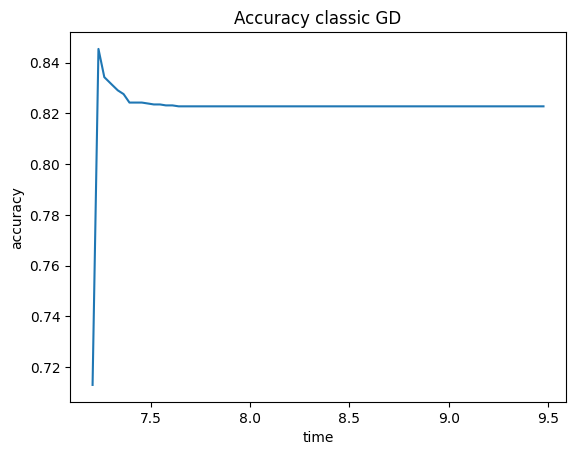

In [ ]:
plt.plot(times,accuracies)
plt.xlabel("time")
plt.ylabel("accuracy")
plt.title("Accuracy classic GD")

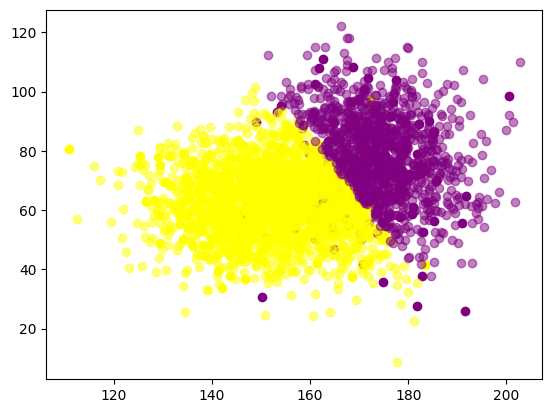

Accuracy: 0.8227660363366703


In [ ]:
#plot of the label assigned and the labelled points

#separate the labelled points between the two classes
X_labelled_0=X_labelled[np.where(y_labelled==0)]
X_labelled_1=X_labelled[np.where(y_labelled==1)]

#separate the unlabelled points between the two predicted classes
X_unlabelled_0=X_unlabelled[np.where(y_unl==0)]
X_unlabelled_1=X_unlabelled[np.where(y_unl==1)]

#plot of the labelled points
plt.scatter(X_labelled_0[:, 0], X_labelled_0[:, 1], c='yellow')
plt.scatter(X_labelled_1[:, 0], X_labelled_1[:, 1], c='purple')

#plot of the unlabelled points
plt.scatter(X_unlabelled_0[:, 0], X_unlabelled_0[:, 1], c='yellow', alpha=0.5)
plt.scatter(X_unlabelled_1[:, 0], X_unlabelled_1[:, 1], c='purple',alpha=0.5)

plt.show()

#accuracy score
accuracy = accuracy_score(copy_y_unlabelled, y_unl)
print("Accuracy:", accuracy)

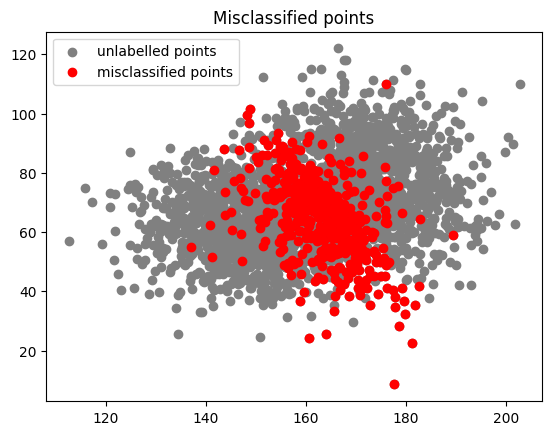

In [ ]:
#plot of just the misclassified points
misclassified_points=[]
for i in range(len(y_unl)):
  if y_unl[i]!=copy_y_unlabelled[i]:
    misclassified_points.append(X_unlabelled[i])
misclassified_points_matrix=np.zeros((len(misclassified_points),2))
for i in range(len(misclassified_points)):
  misclassified_points_matrix[i,:]=misclassified_points[i]
plt.scatter(X_unlabelled[:, 0], X_unlabelled[:, 1], c='grey', label="unlabelled points")
plt.scatter(misclassified_points_matrix[:,0],misclassified_points_matrix[:,1],c='red', label="misclassified points")
plt.legend(loc="upper left")
plt.title("Misclassified points")
plt.show()

In this case a couple of misclassified points are outliers

###BCGD with randomized rule

In [ ]:
#define initial value
y_unl_bcgd=np.zeros(len(y_unlabelled))+.5
previous_grad=gradient(y_unl_bcgd)
times2=[]
accuracies2=[]
max_iter=max_iter*len(y_unl_bcgd)
start_time=time.perf_counter()
for iter in range(max_iter):
  i=random.randint(0,len(y_unl_bcgd)-1)
  prev=y_unl_bcgd.copy()
  y_unl_bcgd[i]= y_unl_bcgd[i] - alpha * previous_grad[i]
  previous_grad=update_gradient(previous_grad,i)
  current_time=time.perf_counter()
  times2.append(current_time-start_time)
  accuracies2.append(accuracy_score(copy_y_unlabelled, np.round(y_unl_bcgd)))
  if EPSILON >= np.linalg.norm(previous_grad):
        break

y_unl_bcgd=np.clip(y_unl_bcgd,0,1)
y_unl_bcgd=np.round(y_unl_bcgd)

#print solution and number of iterations
print("Minimum point:", y_unl_bcgd)
print("Number of iteration",iter+1)

Minimum point: [1. 0. 0. ... 1. 1. 0.]
Number of iteration 185197


Text(0.5, 1.0, 'Accuracy BCGD with randomized rule')

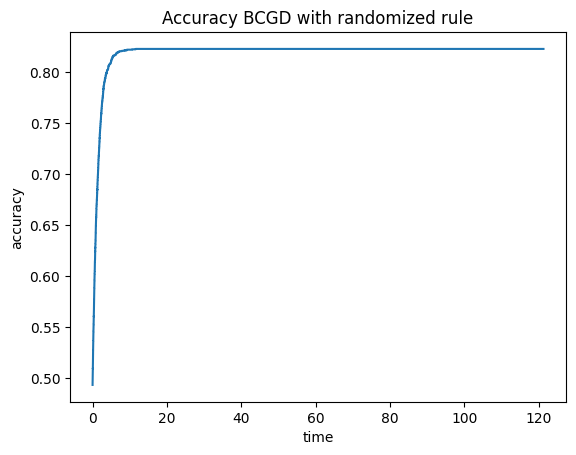

In [ ]:
plt.plot(times2,accuracies2)
plt.xlabel("time")
plt.ylabel("accuracy")
plt.title("Accuracy BCGD with randomized rule")

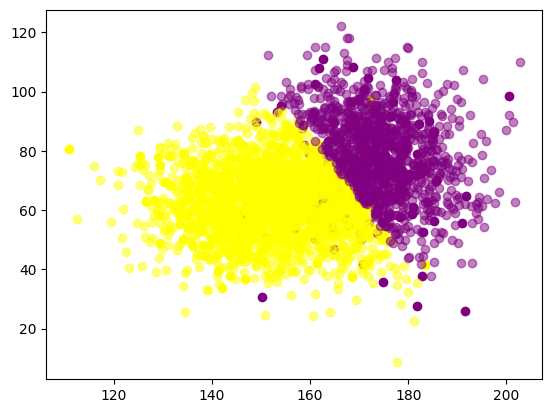

Accuracy: 0.8227660363366703


In [ ]:
#plot of the label assigned and the labelled points

#separate the labelled points between the two classes
X_labelled_0=X_labelled[np.where(y_labelled==0)]
X_labelled_1=X_labelled[np.where(y_labelled==1)]

#separate the unlabelled points between the two predicted classes
X_unlabelled_0=X_unlabelled[np.where(y_unl_bcgd==0)]
X_unlabelled_1=X_unlabelled[np.where(y_unl_bcgd==1)]

#plot of the labelled points
plt.scatter(X_labelled_0[:, 0], X_labelled_0[:, 1], c='yellow')
plt.scatter(X_labelled_1[:, 0], X_labelled_1[:, 1], c='purple')

#plot of the unlabelled points
plt.scatter(X_unlabelled_0[:, 0], X_unlabelled_0[:, 1], c='yellow', alpha=0.5)
plt.scatter(X_unlabelled_1[:, 0], X_unlabelled_1[:, 1], c='purple',alpha=0.5)

plt.show()

#accuracy score
accuracy = accuracy_score(copy_y_unlabelled, y_unl_bcgd)
print("Accuracy:", accuracy)

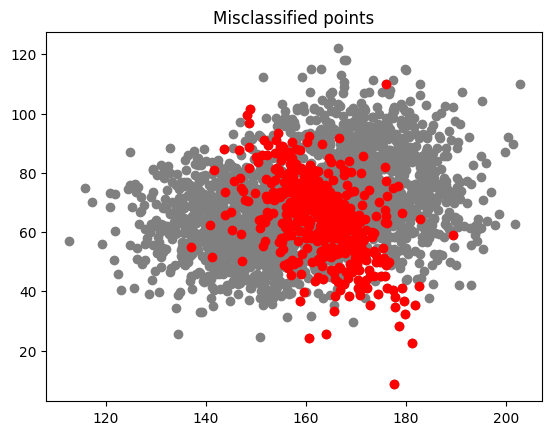

In [ ]:
#plot of just the misclassified points
misclassified_points=[]
for i in range(len(y_unl_bcgd)):
  if y_unl_bcgd[i]!=copy_y_unlabelled[i]:
    misclassified_points.append(X_unlabelled[i])
misclassified_points_matrix=np.zeros((len(misclassified_points),2))
for i in range(len(misclassified_points)):
  misclassified_points_matrix[i,:]=misclassified_points[i]
plt.scatter(X_unlabelled[:, 0], X_unlabelled[:, 1], c='grey', label="unlabelled points")
plt.scatter(misclassified_points_matrix[:,0],misclassified_points_matrix[:,1],c='red', label="misclassified points")
plt.title("Misclassified points")
plt.show()

###BCGD with GS rule

In [ ]:
y_unl_gs=np.zeros(len(y_unlabelled))+.5
previous_grad=gradient(y_unl_gs)
times3=[]
start_time=time.perf_counter()
accuracies3=[]
for iter in range(max_iter*len(y_unl_gs)):
  abs_previous_grad=np.abs(previous_grad)
  i=np.argmax(abs_previous_grad)  
  y_unl_gs[i]= y_unl_gs[i] - alpha * previous_grad[i]
  previous_grad=update_gradient(previous_grad,i)
  current_time=time.perf_counter()
  times3.append(current_time-start_time)
  accuracies3.append(accuracy_score(copy_y_unlabelled,np.round( y_unl_gs)))
  if EPSILON >= np.linalg.norm(previous_grad):
    break
y_unl_gs=np.clip(y_unl_gs,0,1)
y_unl_gs=np.round(y_unl_gs)

#print solution and number of iterations
print("Minimum point:", y_unl_gs)
print("Number of iteration",iter+1)

Minimum point: [1. 0. 0. ... 1. 1. 0.]
Number of iteration 33874


Text(0.5, 1.0, 'Accuracy BCGD with GS rule')

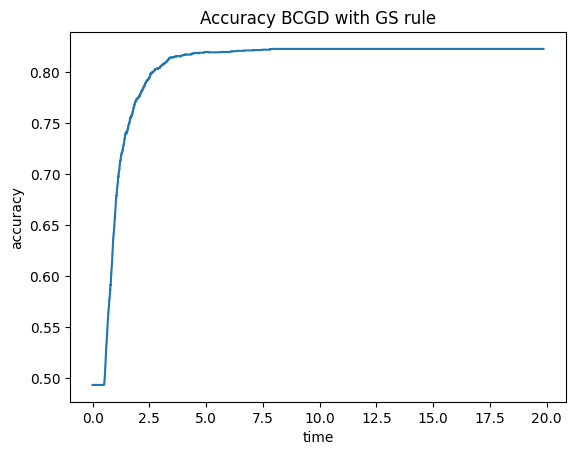

In [ ]:
plt.plot(times3,accuracies3)
plt.xlabel("time")
plt.ylabel("accuracy")
plt.title("Accuracy BCGD with GS rule")

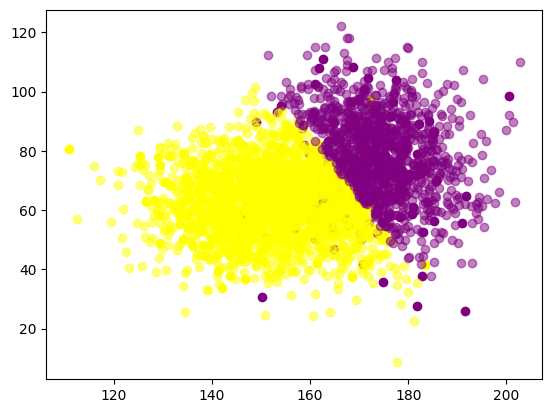

Accuracy: 0.8227660363366703


In [ ]:
#plot of the label assigned and the labelled points

#separate the labelled points between the two classes
X_labelled_0=X_labelled[np.where(y_labelled==0)]
X_labelled_1=X_labelled[np.where(y_labelled==1)]

#separate the unlabelled points between the two predicted classes
X_unlabelled_0=X_unlabelled[np.where(y_unl_gs==0)]
X_unlabelled_1=X_unlabelled[np.where(y_unl_gs==1)]

#plot of the labelled points
plt.scatter(X_labelled_0[:, 0], X_labelled_0[:, 1], c='yellow')
plt.scatter(X_labelled_1[:, 0], X_labelled_1[:, 1], c='purple')

#plot of the unlabelled points
plt.scatter(X_unlabelled_0[:, 0], X_unlabelled_0[:, 1], c='yellow', alpha=0.5)
plt.scatter(X_unlabelled_1[:, 0], X_unlabelled_1[:, 1], c='purple',alpha=0.5)

plt.show()

#accuracy score
accuracy = accuracy_score(copy_y_unlabelled, y_unl_gs)
print("Accuracy:", accuracy)

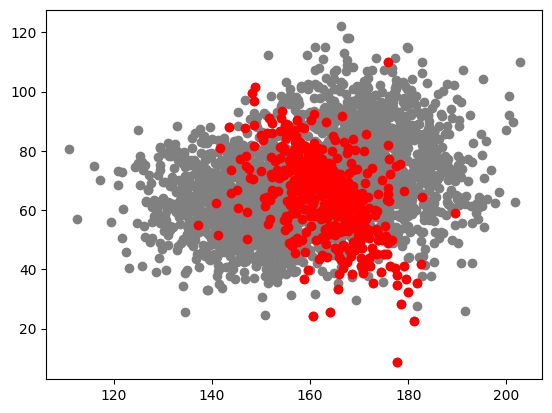

In [ ]:
#plot of just the misclassified points
misclassified_points=[]
for i in range(len(y_unl_gs)):
  if y_unl_gs[i]!=copy_y_unlabelled[i]:
    misclassified_points.append(X_unlabelled[i])
misclassified_points_matrix=np.zeros((len(misclassified_points),2))
for i in range(len(misclassified_points)):
  misclassified_points_matrix[i,:]=misclassified_points[i]
plt.scatter(X_labelled[:, 0], X_labelled[:, 1], c='grey')  # Tracciare i punti labelled
plt.scatter(X_unlabelled[:, 0], X_unlabelled[:, 1], c='grey')  # Tracciare i punti unlabelled
plt.scatter(misclassified_points_matrix[:,0],misclassified_points_matrix[:,1],c='red')
plt.show()

##Male and female dataset with some overlapping points removed

In [ ]:
from google.colab import files
files.upload()

Saving Training set.csv to Training set (4).csv


{'Training set.csv': b'\xef\xbb\xbfHeight,Weight,Sex\r\n165.65,35.41,Female\r\n148.53,74.45,Female\r\n167.04,81.22,Male\r\n161.54,71.47,Male\r\n174.31,78.18,Male\r\n143.05,79.27,Female\r\n149.16,63.71,Female\r\n155.80,86.01,Female\r\n145.37,88.33,Female\r\n162.56,87.36,Male\r\n163.84,78.58,Male\r\n172.73,88.08,Male\r\n142.03,56.30,Female\r\n150.17,53.46,Female\r\n188.62,60.95,Male\r\n184.62,72.51,Male\r\n168.43,86.80,Male\r\n171.19,54.12,Male\r\n137.10,73.36,Female\r\n149.42,69.20,Female\r\n147.33,56.01,Female\r\n175.14,107.25,Male\r\n168.04,92.24,Male\r\n158.54,64.44,Male\r\n138.90,68.75,Female\r\n129.27,58.43,Female\r\n173.64,59.52,Female\r\n175.26,62.65,Male\r\n180.09,44.07,Male\r\n144.58,83.36,Female\r\n178.76,66.12,Male\r\n151.53,91.02,Male\r\n168.55,80.20,Male\r\n160.86,63.68,Male\r\n183.83,62.75,Male\r\n179.27,50.04,Male\r\n158.89,60.49,Male\r\n124.37,74.57,Female\r\n140.42,54.64,Female\r\n155.06,84.34,Male\r\n166.62,75.18,Male\r\n172.96,78.39,Male\r\n174.34,84.76,Male\r\n165.09

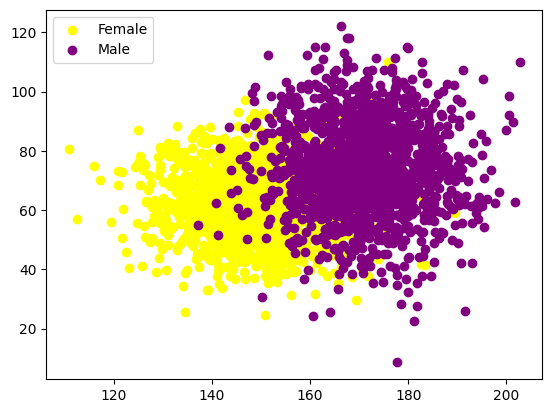

In [ ]:
data=pd.read_csv("Training set.csv")
#removing the outliers in order to have a clear plot
data=data[data['Height']<=1000]
data=data[data['Weight']<200]
data=data[data['Height']>90]


X = np.column_stack((data.Height, data.Weight))
y=data.Sex.values
#changing the value of y to obtain 0/1 instead of "Male"/"Female"
for i in range(len(y)):
  if y[i]=='Female':
    y[i]=0
  else:
    y[i]=1
y = np.array(y).astype(float)

#separate the labelled points between the two classes
X_0=X[np.where(y==0)]
X_1=X[np.where(y==1)]

#plot of the labelled points
plt.scatter(X_0[:, 0], X_0[:, 1], c='yellow',label="Female")
plt.scatter(X_1[:, 0], X_1[:, 1], c='purple',label="Male")

plt.legend(loc="upper left")
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


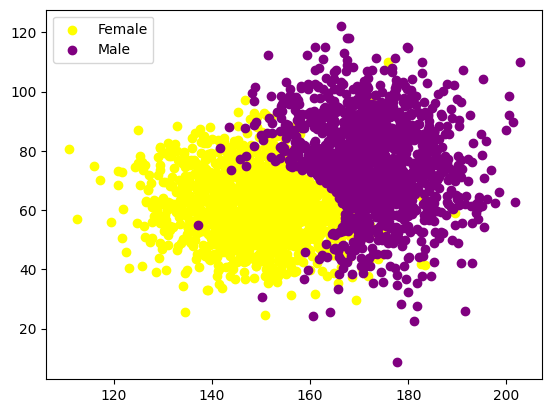

In [ ]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)

# Get the cluster centers
c1,c2 = kmeans.cluster_centers_

labelc1,labelc2 = kmeans.predict([c1,c2])

new_indices=[]
for i in range(len(X)):
  if ((np.linalg.norm(X[i] - c1)>15) and (y[i]==labelc2)) or ((np.linalg.norm(X[i] - c2)>15) and (y[i])==labelc1):
    new_indices.append(i)
X=X[new_indices]
y=y[new_indices]
#separate the labelled points between the two classes
X_0=X[np.where(y==0)]
X_1=X[np.where(y==1)]

#plot of the labelled points
plt.scatter(X_0[:, 0], X_0[:, 1], c='yellow',label="Female")
plt.scatter(X_1[:, 0], X_1[:, 1], c='purple',label="Male")

plt.legend(loc="upper left")
plt.show()

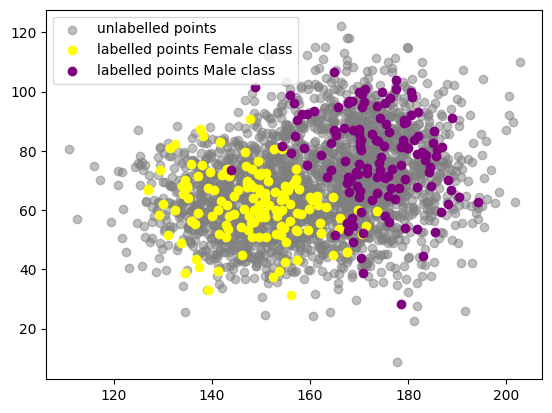

In [ ]:
from sklearn.model_selection import train_test_split
X_labelled,X_unlabelled,y_labelled,y_unlabelled=train_test_split(X,y, test_size=0.9, random_state=0)
#divide X_labelled betwee the two classes
X_labelled_0=X_labelled[np.where(y_labelled==0)]
X_labelled_1=X_labelled[np.where(y_labelled==1)]

#plot the different classes
plt.scatter(X_unlabelled[:, 0], X_unlabelled[:, 1], c='gray', alpha=0.5, label="unlabelled points") 
plt.scatter(X_labelled_0[:, 0], X_labelled_0[:, 1], c='yellow', label="labelled points Female class")
plt.scatter(X_labelled_1[:, 0], X_labelled_1[:, 1], c='purple', label="labelled points Male class")   

copy_y_unlabelled=y_unlabelled.copy()
for i in range(len(y_unlabelled)):
  y_unlabelled[i]=-1

plt.legend(loc="upper left")
plt.show()
for i in range(len(y_unlabelled)):
  y_unlabelled[i]=-1

In [ ]:
# Compute the pairwise distance matrix
distance_matrix = pairwise_distances(X)
#print(distance_matrix)

# Compute the weights for the labeled points and the unlabeled points
labelled_indices = np.where(y_labelled != -1)
unlabelled_indices = np.where(y_unlabelled == -1)
gamma = 1 / (2 * np.median(distance_matrix) ** 2)
weights_labelled = rbf_kernel(X_labelled, X_unlabelled, gamma=gamma)
weights_unlabelled = rbf_kernel(distance_matrix[np.ix_(unlabelled_indices[0], labelled_indices[0])], gamma=gamma)

# Compute the weights for the unlabeled-unlabeled points
unlabelled_indices_1, unlabelled_indices_2 = np.meshgrid(unlabelled_indices, unlabelled_indices)
unlabelled_distances = distance_matrix[unlabelled_indices_1, unlabelled_indices_2]
unlabelled_weights = rbf_kernel(unlabelled_distances, gamma=gamma)

In [ ]:
# define objective function
def objective(y_un):
  global y_labelled,weights_labelled,weights_unlabelled
  result = 0
  for i in range(len(y_labelled)):
    for j in range(len(y_un)):
      result += weights_labelled[i][j] *((y_labelled[i] - y_un[j]) ** 2)
  
  for i in range(len(y_un)):
    for j in range(len(y_un)):
      result+=(1/2)*( weights_unlabelled[i][j]*((y_un[i]-y_un[j])**2))
  return result


# define gradient of objective function
def gradient(y_un):
  global y_labelled,weights_labelled,weights_unlabelled
  result = np.zeros(len(y_un))
  for i in range(len(y_labelled)):
    for j in range(len(y_un)):
      result[j] += 2* weights_labelled[i][j] * (y_un[j]-y_labelled[i])
  
  for i in range(len(y_un)):
    for j in range(len(y_un)):
      result[j] +=2* weights_unlabelled[i][j]*(y_un[i]-y_un[j])
  return result

In [ ]:
#update all the gradient
label_unlabel = np.sum(weights_labelled, axis=0).reshape((-1,1))
unlabel_unlabel = np.sum(weights_unlabelled, axis=0).reshape((-1,1))
coeff_vector = (2 * label_unlabel + unlabel_unlabel)

def update_full_gradient(prev_grad):
  result = np.copy(prev_grad)
  for i in range(len(result)):
    result += weights_unlabelled[i] * alpha*prev_grad[i]   
    result[i] -= coeff_vector[i] * alpha*prev_grad[i]
  return result

#update just one component
def update_gradient(prev_grad,i):
  result = np.copy(prev_grad)
  result += weights_unlabelled[i] * alpha*prev_grad[i]
  result[i] -= coeff_vector[i] * alpha*prev_grad[i]
  return result

def objective_np(y_labelled,y_un):
  global weights_labelled, weights_unlabelled
  result=0
  y_labelled = np.array(y_labelled)  
  weights_labelled = np.array(weights_labelled)
  weights_unlabelled = np.array(weights_unlabelled)

  diff_labelled = y_labelled[:, np.newaxis] - y_un
  result += np.sum(weights_labelled * diff_labelled**2)

  diff_unlabelled = y_un[:, np.newaxis] - y_un
  result += (1/2) * np.sum(weights_unlabelled * diff_unlabelled**2)
  return result

In [ ]:
mat = np.copy(-weights_unlabelled)
for i in range(len(y_unlabelled)):
  mat[i][i] = 2 * np.sum(weights_labelled[:,i]) + np.sum(weights_unlabelled[:,i]) - weights_unlabelled[i][i]

eigvals = np.linalg.eigvals(mat) 
L=max(eigvals)
print(L)
alpha=1/L
print(alpha)

449.3504581952652
0.002225434472719398


In [ ]:
#set the parameters (the value of alpha was already set using the hessian matrix)
max_iter=100
EPSILON=1e-4

In [ ]:
# define initial guess
y_unl=np.zeros(len(y_unlabelled))+1
# run gradient descent algorithm
start_time = time.perf_counter()
times=[]
accuracies=[]
grad=gradient(y_unl)
for iter in range(max_iter):
    y_unl = y_unl - alpha * grad
    current_time = time.perf_counter()
    times.append(current_time-start_time)
    accuracies.append(accuracy_score(copy_y_unlabelled, np.round(y_unl)))
    grad=update_full_gradient(grad)
    if EPSILON >= np.linalg.norm(grad):
        break
y_unl=np.clip(y_unl,0,1)
y_unl=np.round(y_unl)
end_time = time.perf_counter()
# print solution and number of ierations
print("Minimum point:", y_unl)
print("Number of iteration",iter+1)

Minimum point: [0. 1. 1. ... 0. 1. 1.]
Number of iteration 90


Text(0.5, 1.0, 'Accuracy classic GD')

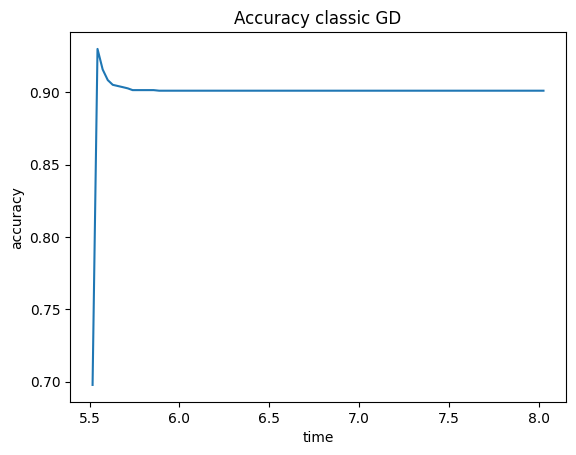

In [ ]:
plt.plot(times,accuracies)
plt.xlabel("time")
plt.ylabel("accuracy")
plt.title("Accuracy classic GD")

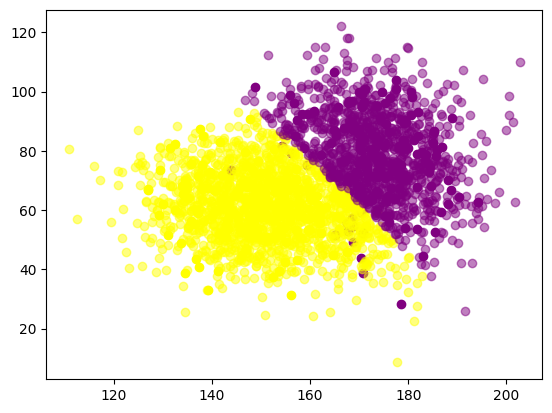

Accuracy: 0.9011391375101708


In [ ]:
#plot of the label assigned and the labelled points

#separate the labelled points between the two classes
X_labelled_0=X_labelled[np.where(y_labelled==0)]
X_labelled_1=X_labelled[np.where(y_labelled==1)]

#separate the unlabelled points between the two predicted classes
X_unlabelled_0=X_unlabelled[np.where(y_unl==0)]
X_unlabelled_1=X_unlabelled[np.where(y_unl==1)]

#plot of the labelled points
plt.scatter(X_labelled_0[:, 0], X_labelled_0[:, 1], c='yellow')
plt.scatter(X_labelled_1[:, 0], X_labelled_1[:, 1], c='purple')

#plot of the unlabelled points
plt.scatter(X_unlabelled_0[:, 0], X_unlabelled_0[:, 1], c='yellow', alpha=0.5)
plt.scatter(X_unlabelled_1[:, 0], X_unlabelled_1[:, 1], c='purple',alpha=0.5)

plt.show()

#accuracy score
accuracy = accuracy_score(copy_y_unlabelled, y_unl)
print("Accuracy:", accuracy)

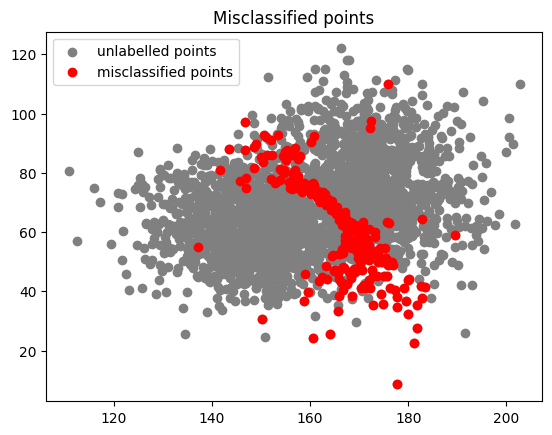

In [ ]:
#plot of just the misclassified points
misclassified_points=[]
for i in range(len(y_unl)):
  if y_unl[i]!=copy_y_unlabelled[i]:
    misclassified_points.append(X_unlabelled[i])
misclassified_points_matrix=np.zeros((len(misclassified_points),2))
for i in range(len(misclassified_points)):
  misclassified_points_matrix[i,:]=misclassified_points[i]
plt.scatter(X_unlabelled[:, 0], X_unlabelled[:, 1], c='grey', label="unlabelled points") 
plt.scatter(misclassified_points_matrix[:,0],misclassified_points_matrix[:,1],c='red', label="misclassified points")
plt.legend(loc="upper left")
plt.title("Misclassified points")
plt.show()

In [ ]:
#define initial value
y_unl_bcgd=np.zeros(len(y_unlabelled))+.5
previous_grad=gradient(y_unl_bcgd)
obj=objective(y_unl_bcgd)
times2=[]
accuracies2=[]
max_iter=max_iter*len(y_unl_bcgd)
start_time=time.perf_counter()
for iter in range(max_iter):
  i=random.randint(0,len(y_unl_bcgd)-1)
  prev=y_unl_bcgd.copy()
  y_unl_bcgd[i]= y_unl_bcgd[i] - alpha * previous_grad[i]
  previous_grad=update_gradient(previous_grad,i)
  current_time=time.perf_counter()
  times2.append(current_time-start_time)
  accuracies2.append(accuracy_score(copy_y_unlabelled, np.round(y_unl_bcgd)))
  if EPSILON >= np.linalg.norm(previous_grad):
        break

y_unl_bcgd=np.clip(y_unl_bcgd,0,1)
y_unl_bcgd=np.round(y_unl_bcgd)

#print solution and number of iterations
print("Minimum point:", y_unl_bcgd)
print("Number of iteration",iter+1)

Minimum point: [0. 1. 1. ... 0. 1. 1.]
Number of iteration 202715


Text(0.5, 1.0, 'Accuracy BCGD with randomized rule')

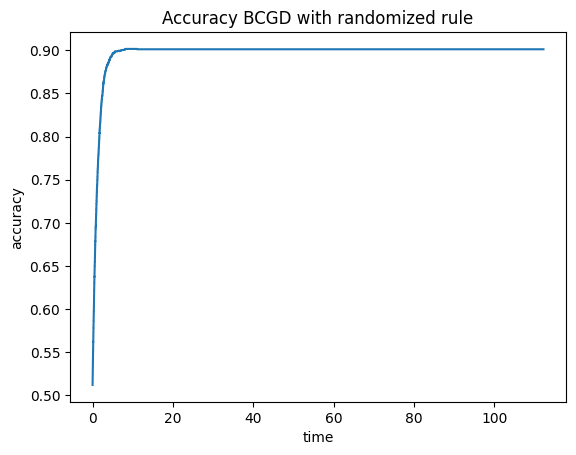

In [ ]:
plt.plot(times2,accuracies2)
plt.xlabel("time")
plt.ylabel("accuracy")
plt.title("Accuracy BCGD with randomized rule")

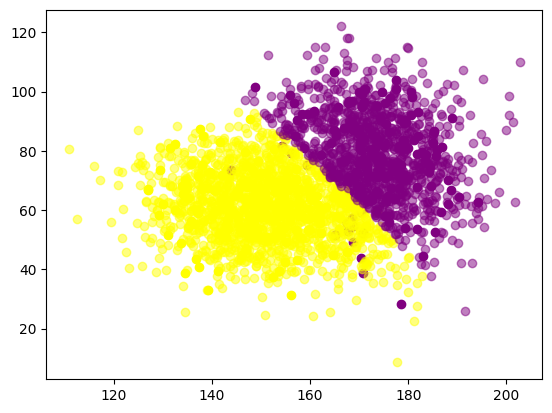

Accuracy: 0.9011391375101708


In [ ]:
#plot of the label assigned and the labelled points

#separate the labelled points between the two classes
X_labelled_0=X_labelled[np.where(y_labelled==0)]
X_labelled_1=X_labelled[np.where(y_labelled==1)]

#separate the unlabelled points between the two predicted classes
X_unlabelled_0=X_unlabelled[np.where(y_unl_bcgd==0)]
X_unlabelled_1=X_unlabelled[np.where(y_unl_bcgd==1)]

#plot of the labelled points
plt.scatter(X_labelled_0[:, 0], X_labelled_0[:, 1], c='yellow')
plt.scatter(X_labelled_1[:, 0], X_labelled_1[:, 1], c='purple')

#plot of the unlabelled points
plt.scatter(X_unlabelled_0[:, 0], X_unlabelled_0[:, 1], c='yellow', alpha=0.5)
plt.scatter(X_unlabelled_1[:, 0], X_unlabelled_1[:, 1], c='purple',alpha=0.5)

plt.show()

#accuracy score
accuracy = accuracy_score(copy_y_unlabelled, y_unl_bcgd)
print("Accuracy:", accuracy)

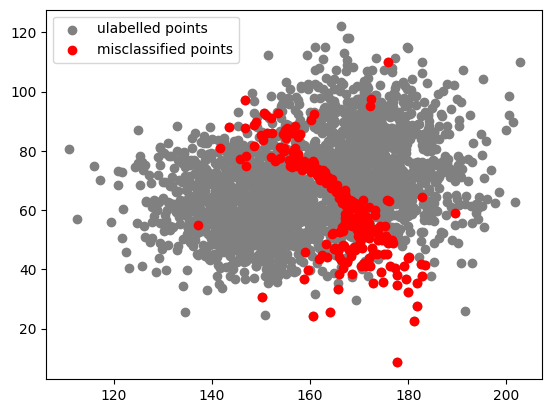

In [ ]:
#plot of just the misclassified points
misclassified_points=[]
for i in range(len(y_unl_bcgd)):
  if y_unl_bcgd[i]!=copy_y_unlabelled[i]:
    misclassified_points.append(X_unlabelled[i])
misclassified_points_matrix=np.zeros((len(misclassified_points),2))
for i in range(len(misclassified_points)):
  misclassified_points_matrix[i,:]=misclassified_points[i]
plt.scatter(X_unlabelled[:, 0], X_unlabelled[:, 1], c='grey', label="ulabelled points")  
plt.scatter(misclassified_points_matrix[:,0],misclassified_points_matrix[:,1],c='red',label="misclassified points")
plt.legend(loc="upper left")
plt.show()

In [ ]:
y_unl_gs=np.zeros(len(y_unlabelled))+.5
previous_grad=gradient(y_unl_gs)
times3=[]
start_time=time.perf_counter()
accuracies3=[]
for iter in range(max_iter*len(y_unl_gs)):
  abs_previous_grad=np.abs(previous_grad)
  i=np.argmax(abs_previous_grad)  
  y_unl_gs[i]= y_unl_gs[i] - alpha * previous_grad[i]
  previous_grad=update_gradient(previous_grad,i)
  current_time=time.perf_counter()
  times3.append(current_time-start_time)
  accuracies3.append(accuracy_score(copy_y_unlabelled,np.round( y_unl_gs)))
  if EPSILON >= np.linalg.norm(previous_grad):
    break
y_unl_gs=np.clip(y_unl_gs,0,1)
y_unl_gs=np.round(y_unl_gs)

#print solution and number of iterations
print("Minimum point:", y_unl_gs)
print("Number of iteration",iter+1)

Minimum point: [0. 1. 1. ... 0. 1. 1.]
Number of iteration 29674


Text(0.5, 1.0, 'Accuracy BCGD with GS rule')

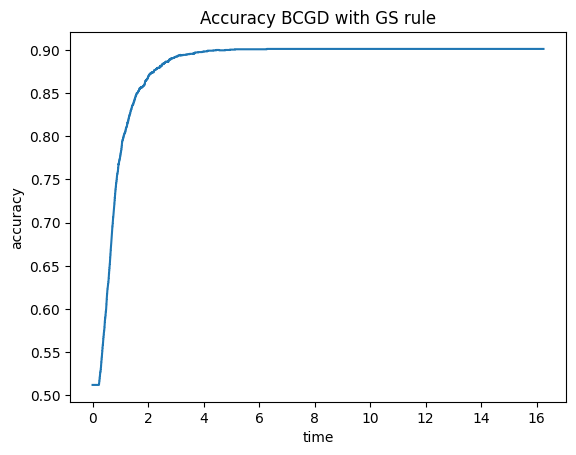

In [ ]:
plt.plot(times3,accuracies3)
plt.xlabel("time")
plt.ylabel("accuracy")
plt.title("Accuracy BCGD with GS rule")

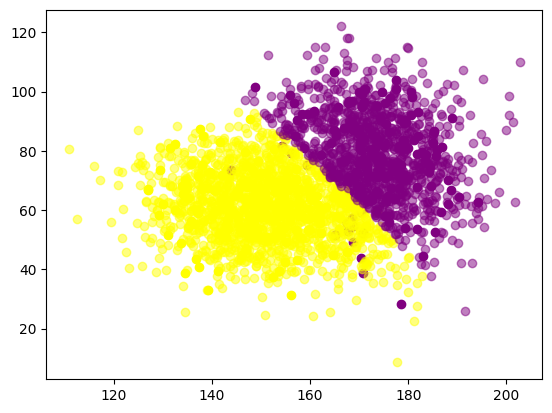

Accuracy: 0.9011391375101708


In [ ]:
#plot of the label assigned and the labelled points

#separate the labelled points between the two classes
X_labelled_0=X_labelled[np.where(y_labelled==0)]
X_labelled_1=X_labelled[np.where(y_labelled==1)]

#separate the unlabelled points between the two predicted classes
X_unlabelled_0=X_unlabelled[np.where(y_unl_gs==0)]
X_unlabelled_1=X_unlabelled[np.where(y_unl_gs==1)]

#plot of the labelled points
plt.scatter(X_labelled_0[:, 0], X_labelled_0[:, 1], c='yellow')
plt.scatter(X_labelled_1[:, 0], X_labelled_1[:, 1], c='purple')

#plot of the unlabelled points
plt.scatter(X_unlabelled_0[:, 0], X_unlabelled_0[:, 1], c='yellow', alpha=0.5)
plt.scatter(X_unlabelled_1[:, 0], X_unlabelled_1[:, 1], c='purple',alpha=0.5)

plt.show()

#accuracy score
accuracy = accuracy_score(copy_y_unlabelled, y_unl_gs)
print("Accuracy:", accuracy)

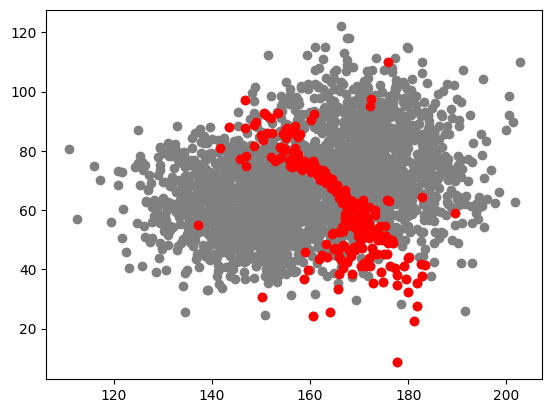

In [ ]:
#plot of just the misclassified points
misclassified_points=[]
for i in range(len(y_unl_gs)):
  if y_unl_gs[i]!=copy_y_unlabelled[i]:
    misclassified_points.append(X_unlabelled[i])
misclassified_points_matrix=np.zeros((len(misclassified_points),2))
for i in range(len(misclassified_points)):
  misclassified_points_matrix[i,:]=misclassified_points[i]
plt.scatter(X_labelled[:, 0], X_labelled[:, 1], c='grey')  # Tracciare i punti labelled
plt.scatter(X_unlabelled[:, 0], X_unlabelled[:, 1], c='grey')  # Tracciare i punti unlabelled
plt.scatter(misclassified_points_matrix[:,0],misclassified_points_matrix[:,1],c='red')
plt.show()

##Large dataset with just 5% of the point labelled

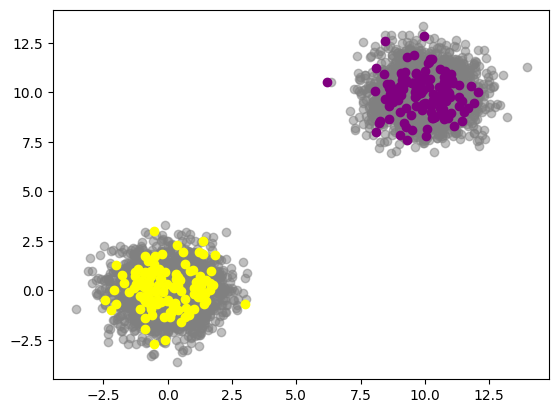

In [ ]:
X, y = make_blobs(n_samples=5000, centers=[[0, 0], [10, 10]], cluster_std=[1, 1])

X_labelled,X_unlabelled,y_labelled,y_unlabelled=train_test_split(X,y, test_size=0.95, random_state=0)
#divide X_labelled betwee the two classes
X_labelled_0=X_labelled[np.where(y_labelled==0)]
X_labelled_1=X_labelled[np.where(y_labelled==1)]

#plot the different classes
plt.scatter(X_unlabelled[:, 0], X_unlabelled[:, 1], c='gray', alpha=0.5, label="unlabelled points") 
plt.scatter(X_labelled_0[:, 0], X_labelled_0[:, 1], c='yellow', label="labelled points with y=0")
plt.scatter(X_labelled_1[:, 0], X_labelled_1[:, 1], c='purple', label="labelled points with y=1")    
copy_y_unlabelled=y_unlabelled.copy()
for i in range(len(y_unlabelled)):
  y_unlabelled[i]=-1

#print(X_unlabelled)
# Mostrare il grafico
plt.show()

In [ ]:
# Compute the pairwise distance matrix
distance_matrix = pairwise_distances(X)
#print(distance_matrix)

# Compute the weights for the labeled points and the unlabeled points
labelled_indices = np.where(y_labelled != -1)
unlabelled_indices = np.where(y_unlabelled == -1)
gamma = 1 / (2 * np.median(distance_matrix) ** 2)
weights_labelled = rbf_kernel(X_labelled, X_unlabelled, gamma=gamma)
weights_unlabelled = rbf_kernel(distance_matrix[np.ix_(unlabelled_indices[0], labelled_indices[0])], gamma=gamma)

# Compute the weights for the unlabeled-unlabeled points
unlabelled_indices_1, unlabelled_indices_2 = np.meshgrid(unlabelled_indices, unlabelled_indices)
unlabelled_distances = distance_matrix[unlabelled_indices_1, unlabelled_indices_2]
unlabelled_weights = rbf_kernel(unlabelled_distances, gamma=gamma)

In [ ]:
mat = np.copy(-weights_unlabelled)
for i in range(len(y_unlabelled)):
  mat[i][i] = 2 * np.sum(weights_labelled[:,i]) + np.sum(weights_unlabelled[:,i]) - weights_unlabelled[i][i]

eigvals = np.linalg.eigvals(mat) 
L=max(eigvals)
print(L)
alpha=1/L
print(alpha)

1092.003350806638
0.0009157481057739637


In [ ]:
import time
def objective(y_un):
  result = 0
  for i in range(len(y_labelled)):
    for j in range(len(y_un)):
      result += weights_labelled[i][j] * (y_labelled[i] - y_un[j]) ** 2
  
  for i in range(len(y_un)):
    for j in range(len(y_un)):
      result+=(1/2)*( weights_unlabelled[i][j]*(y_un[i]-y_un[j])**2)
  return result


# define gradient of objective function
def gradient(y_un):
  result = np.zeros(len(y_un))
  for i in range(len(y_labelled)):
    for j in range(len(y_un)):
      result[j] += 2* weights_labelled[i][j] * (y_un[j]-y_labelled[i])
  
  for i in range(len(y_un)):
    for j in range(len(y_un)):
      result[j] += weights_unlabelled[i][j]*(y_un[i]-y_un[j])
  return result

In [ ]:
#update all the gradient
label_unlabel = np.sum(weights_labelled, axis=0).reshape((-1,1))
unlabel_unlabel = np.sum(weights_unlabelled, axis=0).reshape((-1,1))
coeff_vector = (2 * label_unlabel + unlabel_unlabel)

def update_full_gradient(prev_grad):
  result = np.copy(prev_grad)
  for i in range(len(result)):
    result += weights_unlabelled[i] * alpha*prev_grad[i]   
    result[i] -= coeff_vector[i] * alpha*prev_grad[i]
  return result

#update just one component
def update_gradient(prev_grad,i):
  result = np.copy(prev_grad)
  result += weights_unlabelled[i] * alpha*prev_grad[i]
  result[i] -= coeff_vector[i] * alpha*prev_grad[i]
  return result

def objective_np(y_labelled,y_un):
  global weights_labelled, weights_unlabelled
  result=0
  y_labelled = np.array(y_labelled)  
  weights_labelled = np.array(weights_labelled)
  weights_unlabelled = np.array(weights_unlabelled)

  diff_labelled = y_labelled[:, np.newaxis] - y_un
  result += np.sum(weights_labelled * diff_labelled**2)

  diff_unlabelled = y_un[:, np.newaxis] - y_un
  result += (1/2) * np.sum(weights_unlabelled * diff_unlabelled**2)
  return result

In [ ]:
#define a maximum number of iteration and epsilon such that if the norm of the gradient is smaller
#than epsilon we stop the method
max_iter=100
EPSILON=1e-4
# as learning rate we took the value that we found before

In [ ]:
# define initial guess
y_unl = np.zeros(len(y_unlabelled))+.5
grad=gradient(y_unl)
for iter in range(max_iter):
    y_unl = y_unl - alpha * grad
    grad=update_full_gradient(grad)
    if EPSILON >= np.linalg.norm(grad):
        break
y_unl=np.clip(y_unl,0,1)
y_unl=np.round(y_unl)
end_time = time.perf_counter()
# print solution and number of ierations
print("Minimum point:", y_unl)
print("Number of iteration",iter+1)

Minimum point: [0. 0. 0. ... 0. 1. 1.]
Number of iteration 52


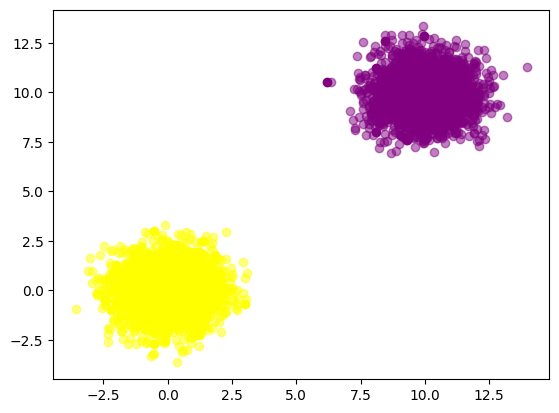

Accuracy: 1.0


In [ ]:
#plot of the label assigned and the labelled points

#separate the labelled points between the two classes
X_labelled_0=X_labelled[np.where(y_labelled==0)]
X_labelled_1=X_labelled[np.where(y_labelled==1)]

#separate the unlabelled points between the two predicted classes
X_unlabelled_0=X_unlabelled[np.where(y_unl==0)]
X_unlabelled_1=X_unlabelled[np.where(y_unl==1)]

#plot of the labelled points
plt.scatter(X_labelled_0[:, 0], X_labelled_0[:, 1], c='yellow')
plt.scatter(X_labelled_1[:, 0], X_labelled_1[:, 1], c='purple')

#plot of the unlabelled points
plt.scatter(X_unlabelled_0[:, 0], X_unlabelled_0[:, 1], c='yellow', alpha=0.5)
plt.scatter(X_unlabelled_1[:, 0], X_unlabelled_1[:, 1], c='purple',alpha=0.5)

plt.show()

#accuracy score
accuracy = accuracy_score(copy_y_unlabelled, y_unl)
print("Accuracy:", accuracy)

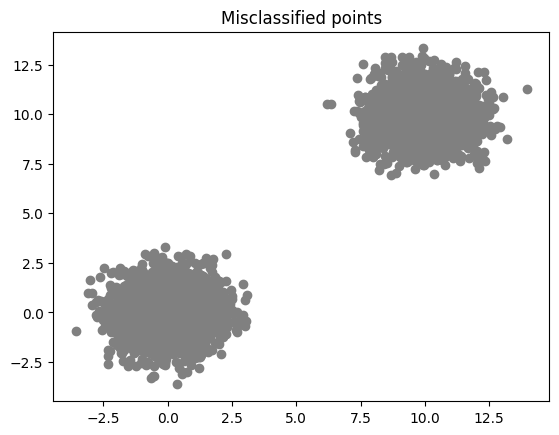

In [ ]:
#plot of just the misclassified points
misclassified_points=[]
for i in range(len(y_unl)):
  if y_unl[i]!=copy_y_unlabelled[i]:
    misclassified_points.append(X_unlabelled[i])
misclassified_points_matrix=np.zeros((len(misclassified_points),2))
for i in range(len(misclassified_points)):
  misclassified_points_matrix[i,:]=misclassified_points[i]
plt.scatter(X_labelled[:, 0], X_labelled[:, 1], c='grey')  # Tracciare i punti labelled
plt.scatter(X_unlabelled[:, 0], X_unlabelled[:, 1], c='grey')  # Tracciare i punti unlabelled
plt.scatter(misclassified_points_matrix[:,0],misclassified_points_matrix[:,1],c='red')
plt.title("Misclassified points")
plt.show()

In [ ]:
y_unl_bcgd=np.zeros(len(y_unlabelled))+.5
previous_grad=gradient(y_unl_bcgd)
for iter in range(max_iter*len(y_unl_bcgd)):
  i=random.randint(0,len(y_unl_bcgd)-1)
  y_unl_bcgd[i]= y_unl_bcgd[i] - alpha * previous_grad[i]
  previous_grad=update_gradient(previous_grad,i)
  if EPSILON >= np.linalg.norm(previous_grad):
        break
        
y_unl_bcgd=np.clip(y_unl_bcgd,0,1)
y_unl_bcgd=y_unl_bcgd.round()

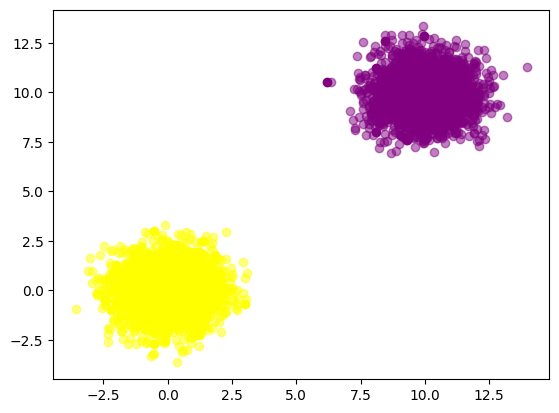

Accuracy: 1.0


In [ ]:
#plot of the label assigned and the labelled points

#separate the labelled points between the two classes
X_labelled_0=X_labelled[np.where(y_labelled==0)]
X_labelled_1=X_labelled[np.where(y_labelled==1)]

#separate the unlabelled points between the two predicted classes
X_unlabelled_0=X_unlabelled[np.where(y_unl_bcgd==0)]
X_unlabelled_1=X_unlabelled[np.where(y_unl_bcgd==1)]

#plot of the labelled points
plt.scatter(X_labelled_0[:, 0], X_labelled_0[:, 1], c='yellow')
plt.scatter(X_labelled_1[:, 0], X_labelled_1[:, 1], c='purple')

#plot of the unlabelled points
plt.scatter(X_unlabelled_0[:, 0], X_unlabelled_0[:, 1], c='yellow', alpha=0.5)
plt.scatter(X_unlabelled_1[:, 0], X_unlabelled_1[:, 1], c='purple',alpha=0.5)

plt.show()

#accuracy score
accuracy = accuracy_score(copy_y_unlabelled, y_unl_bcgd)
print("Accuracy:", accuracy)

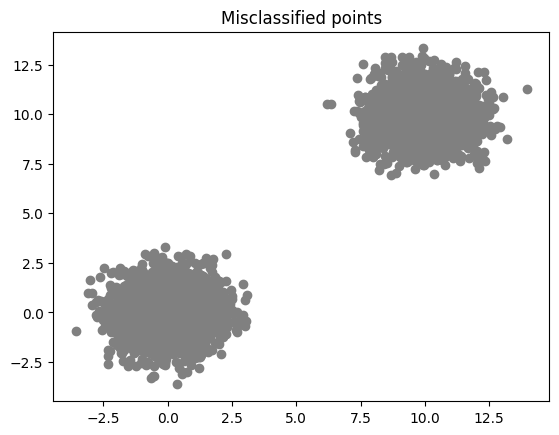

In [ ]:
#plot of just the misclassified points
misclassified_points=[]
for i in range(len(y_unl_bcgd)):
  if y_unl_bcgd[i]!=copy_y_unlabelled[i]:
    misclassified_points.append(X_unlabelled[i])
misclassified_points_matrix=np.zeros((len(misclassified_points),2))
for i in range(len(misclassified_points)):
  misclassified_points_matrix[i,:]=misclassified_points[i]
plt.scatter(X_labelled[:, 0], X_labelled[:, 1], c='grey')  # Tracciare i punti labelled
plt.scatter(X_unlabelled[:, 0], X_unlabelled[:, 1], c='grey')  # Tracciare i punti unlabelled
plt.scatter(misclassified_points_matrix[:,0],misclassified_points_matrix[:,1],c='red')
plt.title("Misclassified points")
plt.show()

In [ ]:
y_unl_gs=np.zeros(len(y_unlabelled))+.5
previous_grad=gradient(y_unl_gs)
for iter in range(max_iter*len(y_unl_gs)):
  abs_previous_grad=np.abs(previous_grad)
  i=np.argmax(abs_previous_grad)  
  y_unl_gs[i]= y_unl_gs[i] - alpha * previous_grad[i]
  #y_unl_gs=np.clip(y_unl_gs,0,1)
  previous_grad=update_gradient(previous_grad,i)
  if EPSILON >= np.linalg.norm(previous_grad):
    break
y_unl_gs=np.clip(y_unl_gs,0,1)
y_unl_gs=np.round(y_unl_gs)

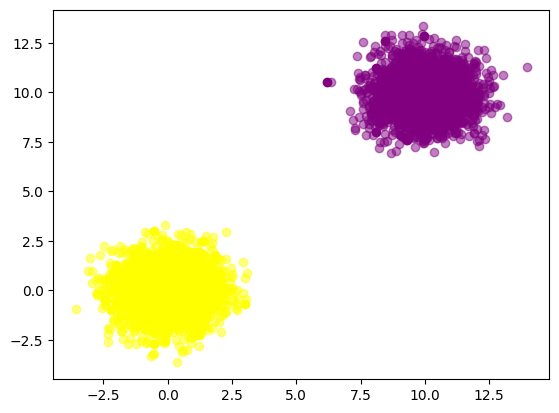

Accuracy: 1.0


In [ ]:
#plot of the label assigned and the labelled points

#separate the labelled points between the two classes
X_labelled_0=X_labelled[np.where(y_labelled==0)]
X_labelled_1=X_labelled[np.where(y_labelled==1)]

#separate the unlabelled points between the two predicted classes
X_unlabelled_0=X_unlabelled[np.where(y_unl_gs==0)]
X_unlabelled_1=X_unlabelled[np.where(y_unl_gs==1)]

#plot of the labelled points
plt.scatter(X_labelled_0[:, 0], X_labelled_0[:, 1], c='yellow')
plt.scatter(X_labelled_1[:, 0], X_labelled_1[:, 1], c='purple')

#plot of the unlabelled points
plt.scatter(X_unlabelled_0[:, 0], X_unlabelled_0[:, 1], c='yellow', alpha=0.5)
plt.scatter(X_unlabelled_1[:, 0], X_unlabelled_1[:, 1], c='purple',alpha=0.5)

plt.show()

#accuracy score
accuracy = accuracy_score(copy_y_unlabelled, y_unl_gs)
print("Accuracy:", accuracy)

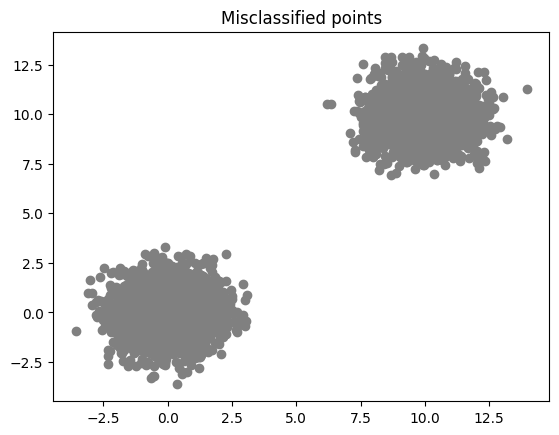

In [ ]:
#plot of just the misclassified points
misclassified_points=[]
for i in range(len(y_unl_gs)):
  if y_unl_gs[i]!=copy_y_unlabelled[i]:
    misclassified_points.append(X_unlabelled[i])
misclassified_points_matrix=np.zeros((len(misclassified_points),2))
for i in range(len(misclassified_points)):
  misclassified_points_matrix[i,:]=misclassified_points[i]
plt.scatter(X_labelled[:, 0], X_labelled[:, 1], c='grey')  # Tracciare i punti labelled
plt.scatter(X_unlabelled[:, 0], X_unlabelled[:, 1], c='grey')  # Tracciare i punti unlabelled
plt.scatter(misclassified_points_matrix[:,0],misclassified_points_matrix[:,1],c='red')
plt.title("Misclassified points")
plt.show()